In [7]:
#!pip install scikit-optimize
#!pip3 install catboost

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import numpy as np
import scipy.stats as stats
import warnings
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2_contingency
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

warnings.filterwarnings("ignore", category=FutureWarning)

In [9]:
data = pd.read_csv(r"/content/fraud_oracle.csv.zip")

In [10]:
#descriptive statistics
data.describe(include='all')

#check missing values
data.isna().sum()

#Display the data type
print(data.dtypes)

Month                   object
WeekOfMonth              int64
DayOfWeek               object
Make                    object
AccidentArea            object
DayOfWeekClaimed        object
MonthClaimed            object
WeekOfMonthClaimed       int64
Sex                     object
MaritalStatus           object
Age                      int64
Fault                   object
PolicyType              object
VehicleCategory         object
VehiclePrice            object
FraudFound_P             int64
PolicyNumber             int64
RepNumber                int64
Deductible               int64
DriverRating             int64
Days_Policy_Accident    object
Days_Policy_Claim       object
PastNumberOfClaims      object
AgeOfVehicle            object
AgeOfPolicyHolder       object
PoliceReportFiled       object
WitnessPresent          object
AgentType               object
NumberOfSuppliments     object
AddressChange_Claim     object
NumberOfCars            object
Year                     int64
BasePoli

#Data Cleaning

In [11]:
print("Missing Values in each column:")
data.isna().sum()

Missing Values in each column:


,0
Month,0
WeekOfMonth,0
DayOfWeek,0
Make,0
AccidentArea,0
DayOfWeekClaimed,0
MonthClaimed,0
WeekOfMonthClaimed,0
Sex,0
MaritalStatus,0


In [12]:
print(data.dtypes)

Month                   object
WeekOfMonth              int64
DayOfWeek               object
Make                    object
AccidentArea            object
DayOfWeekClaimed        object
MonthClaimed            object
WeekOfMonthClaimed       int64
Sex                     object
MaritalStatus           object
Age                      int64
Fault                   object
PolicyType              object
VehicleCategory         object
VehiclePrice            object
FraudFound_P             int64
PolicyNumber             int64
RepNumber                int64
Deductible               int64
DriverRating             int64
Days_Policy_Accident    object
Days_Policy_Claim       object
PastNumberOfClaims      object
AgeOfVehicle            object
AgeOfPolicyHolder       object
PoliceReportFiled       object
WitnessPresent          object
AgentType               object
NumberOfSuppliments     object
AddressChange_Claim     object
NumberOfCars            object
Year                     int64
BasePoli

#Converting Data Types

In [13]:
df = data.copy()

In [14]:
#Data Type conversion
df['FraudFound_P'] = df['FraudFound_P'].astype(bool)
df['Year'] = df['Year'].astype(object)

print(df['FraudFound_P'].dtypes)
print(df['Year'].dtypes)

#Extract numerical and categorical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object','category']).columns

#Convert categorical columns to category dtype
df[categorical_cols] = df[categorical_cols].astype('category')

#displaythe first few few rows again to confirm changes
df.head()

bool
object


,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


## EDA

In [15]:
#Distribution of target variable

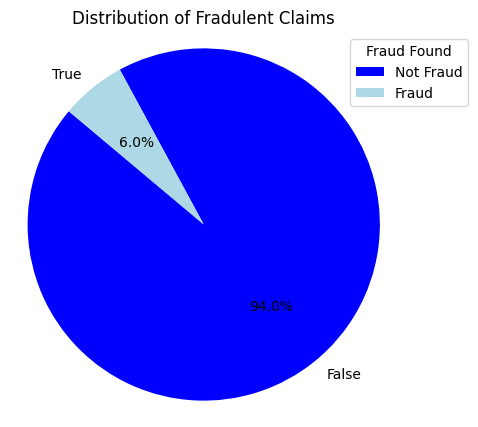

In [16]:
fraud_count = df["FraudFound_P"].value_counts()

#plot the the distribution
plt.figure(figsize=(5,5))
plt.pie(fraud_count, labels=fraud_count.index, autopct='%1.1f%%', startangle=140, colors=['blue', 'lightblue'])
plt.title("Distribution of Fradulent Claims", fontsize=12)
plt.axis("equal")
plt.legend(title="Fraud Found", labels=["Not Fraud", "Fraud"], loc="upper right", bbox_to_anchor=(1.2,1))
plt.show()

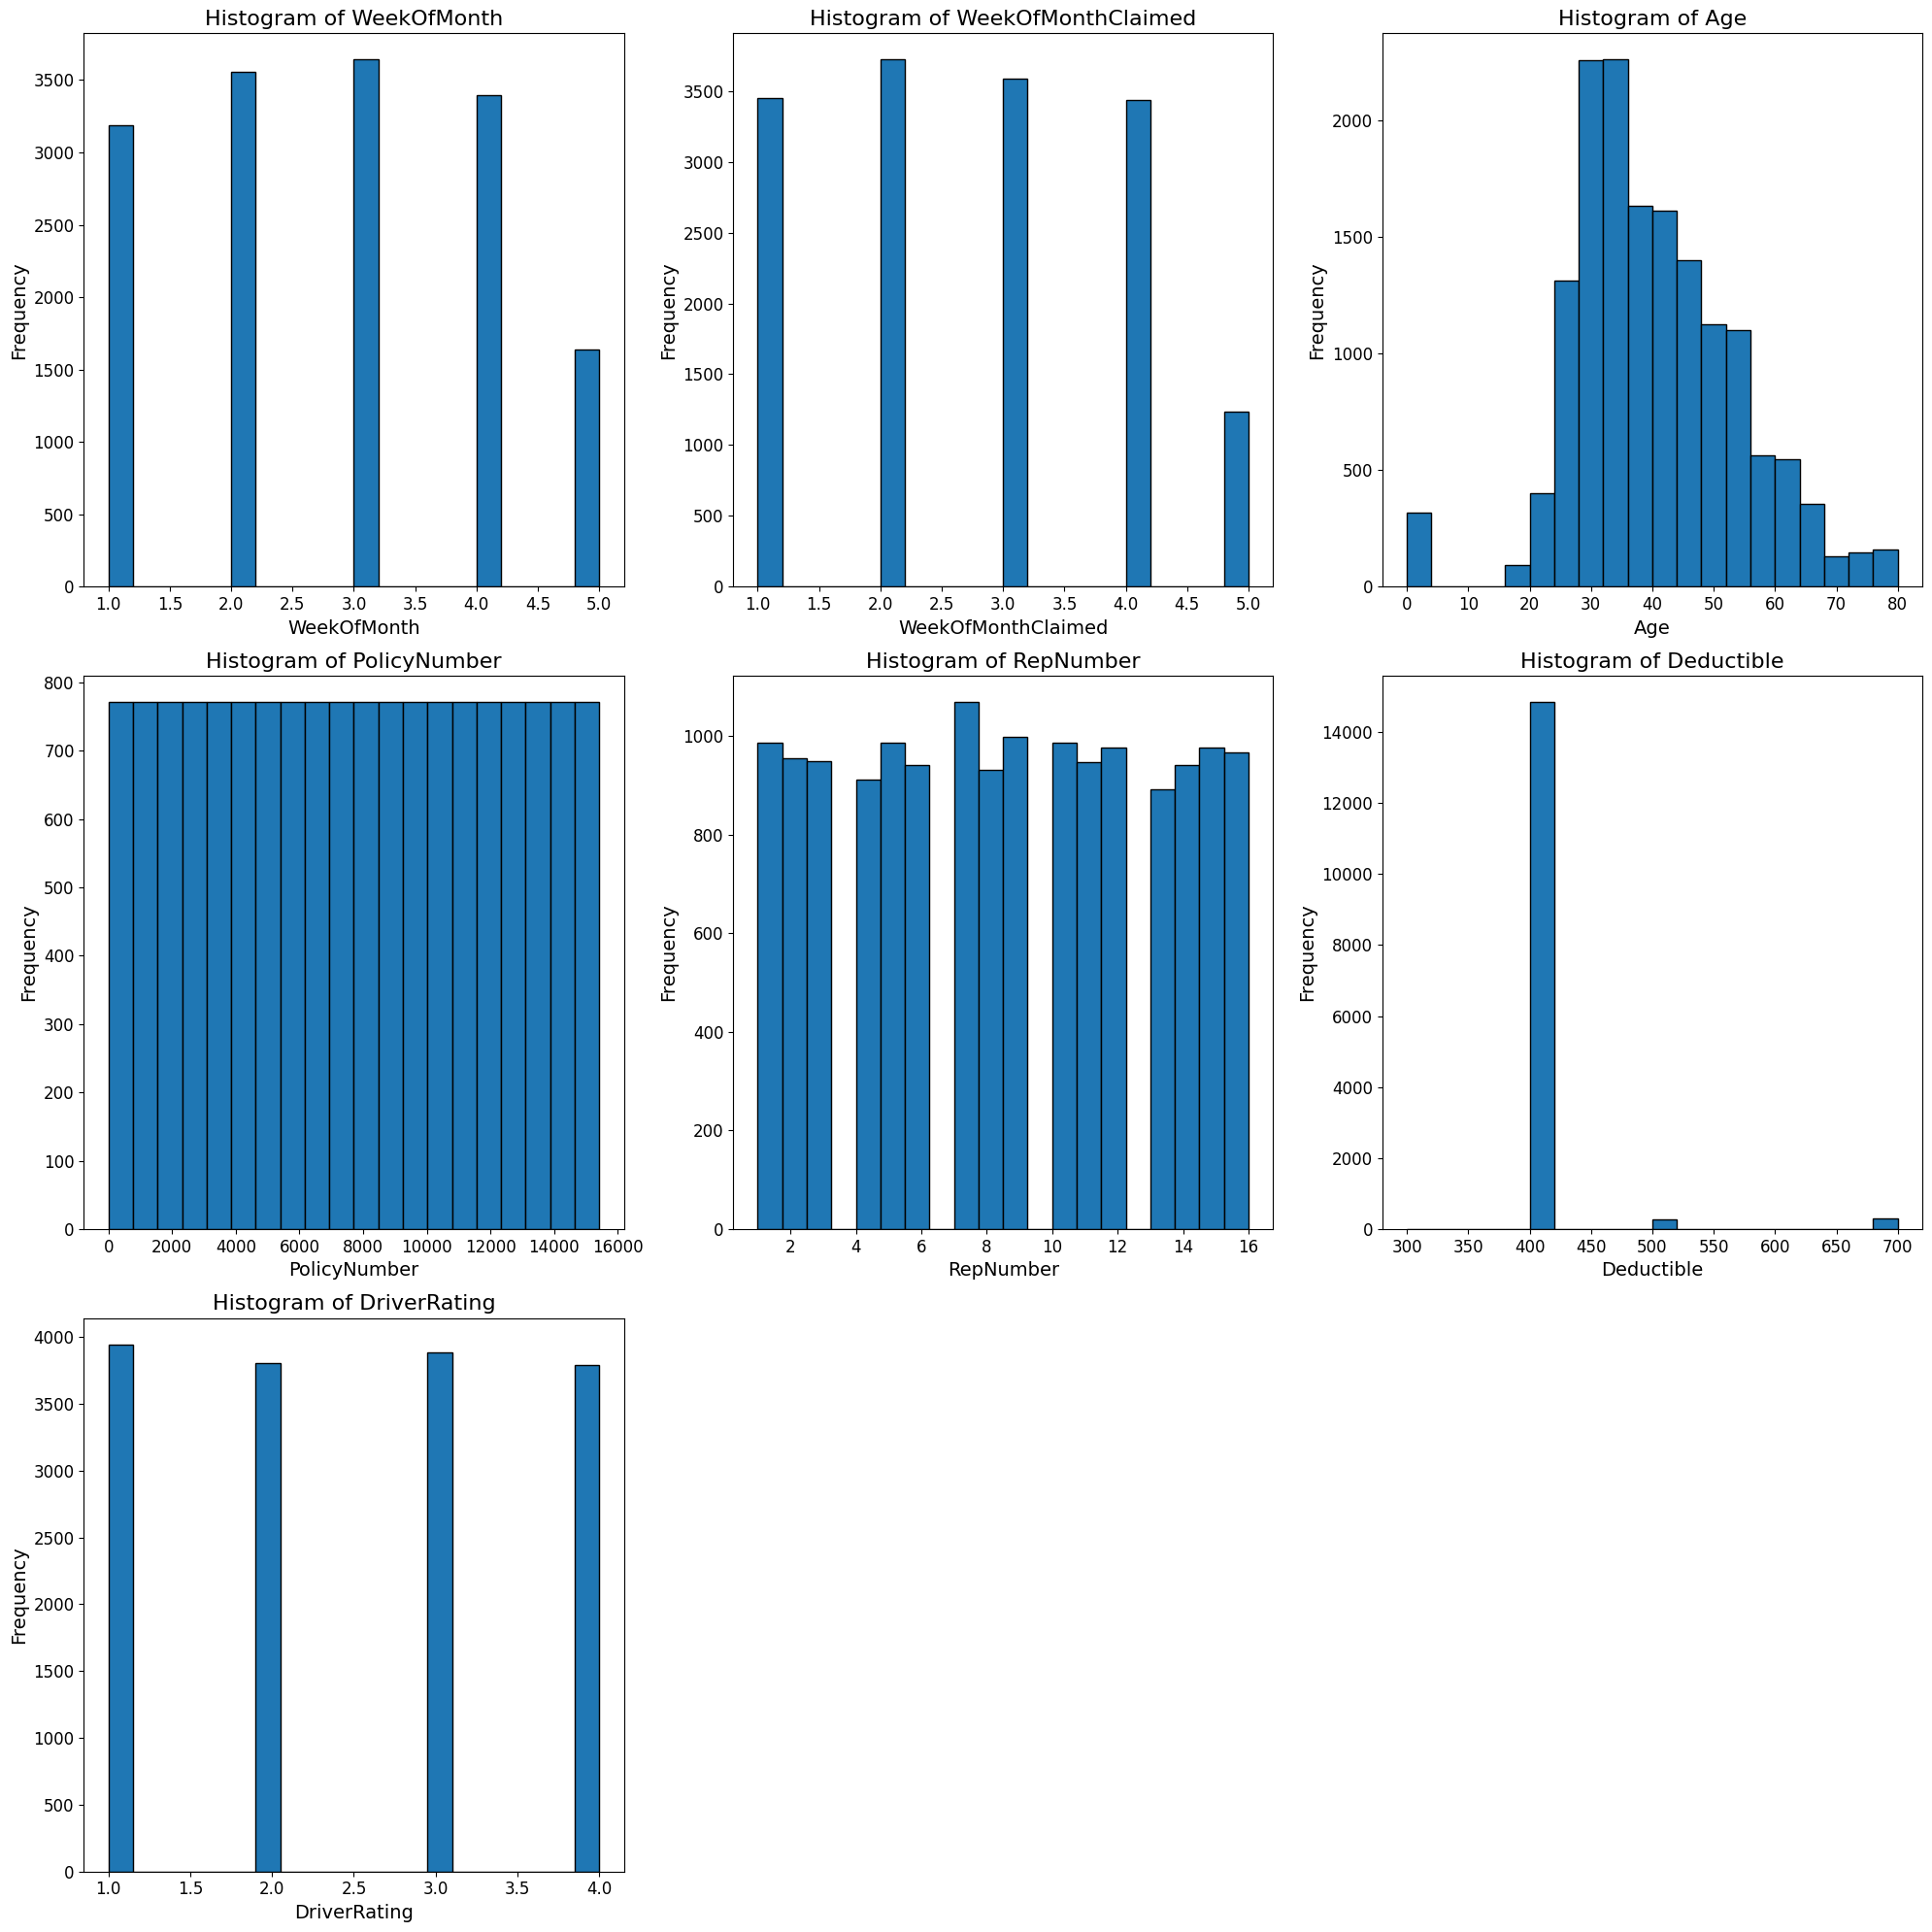

In [17]:
#plot histograms for numerical features
numerical_cols = df.select_dtypes(include=['int64','float64']).columns

#plotting histograms with larger lables for x and y axis
plt.figure(figsize=(20,20))
for i, col in enumerate(numerical_cols):
    plt.subplot((len(numerical_cols) // 3) + 1, 3, i+1)
    plt.hist(df[col], bins=20, edgecolor='black')
    plt.title(f'Histogram of {col}', fontsize=16)
    plt.xlabel(col, fontsize=14)
    plt.ylabel('Frequency',fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

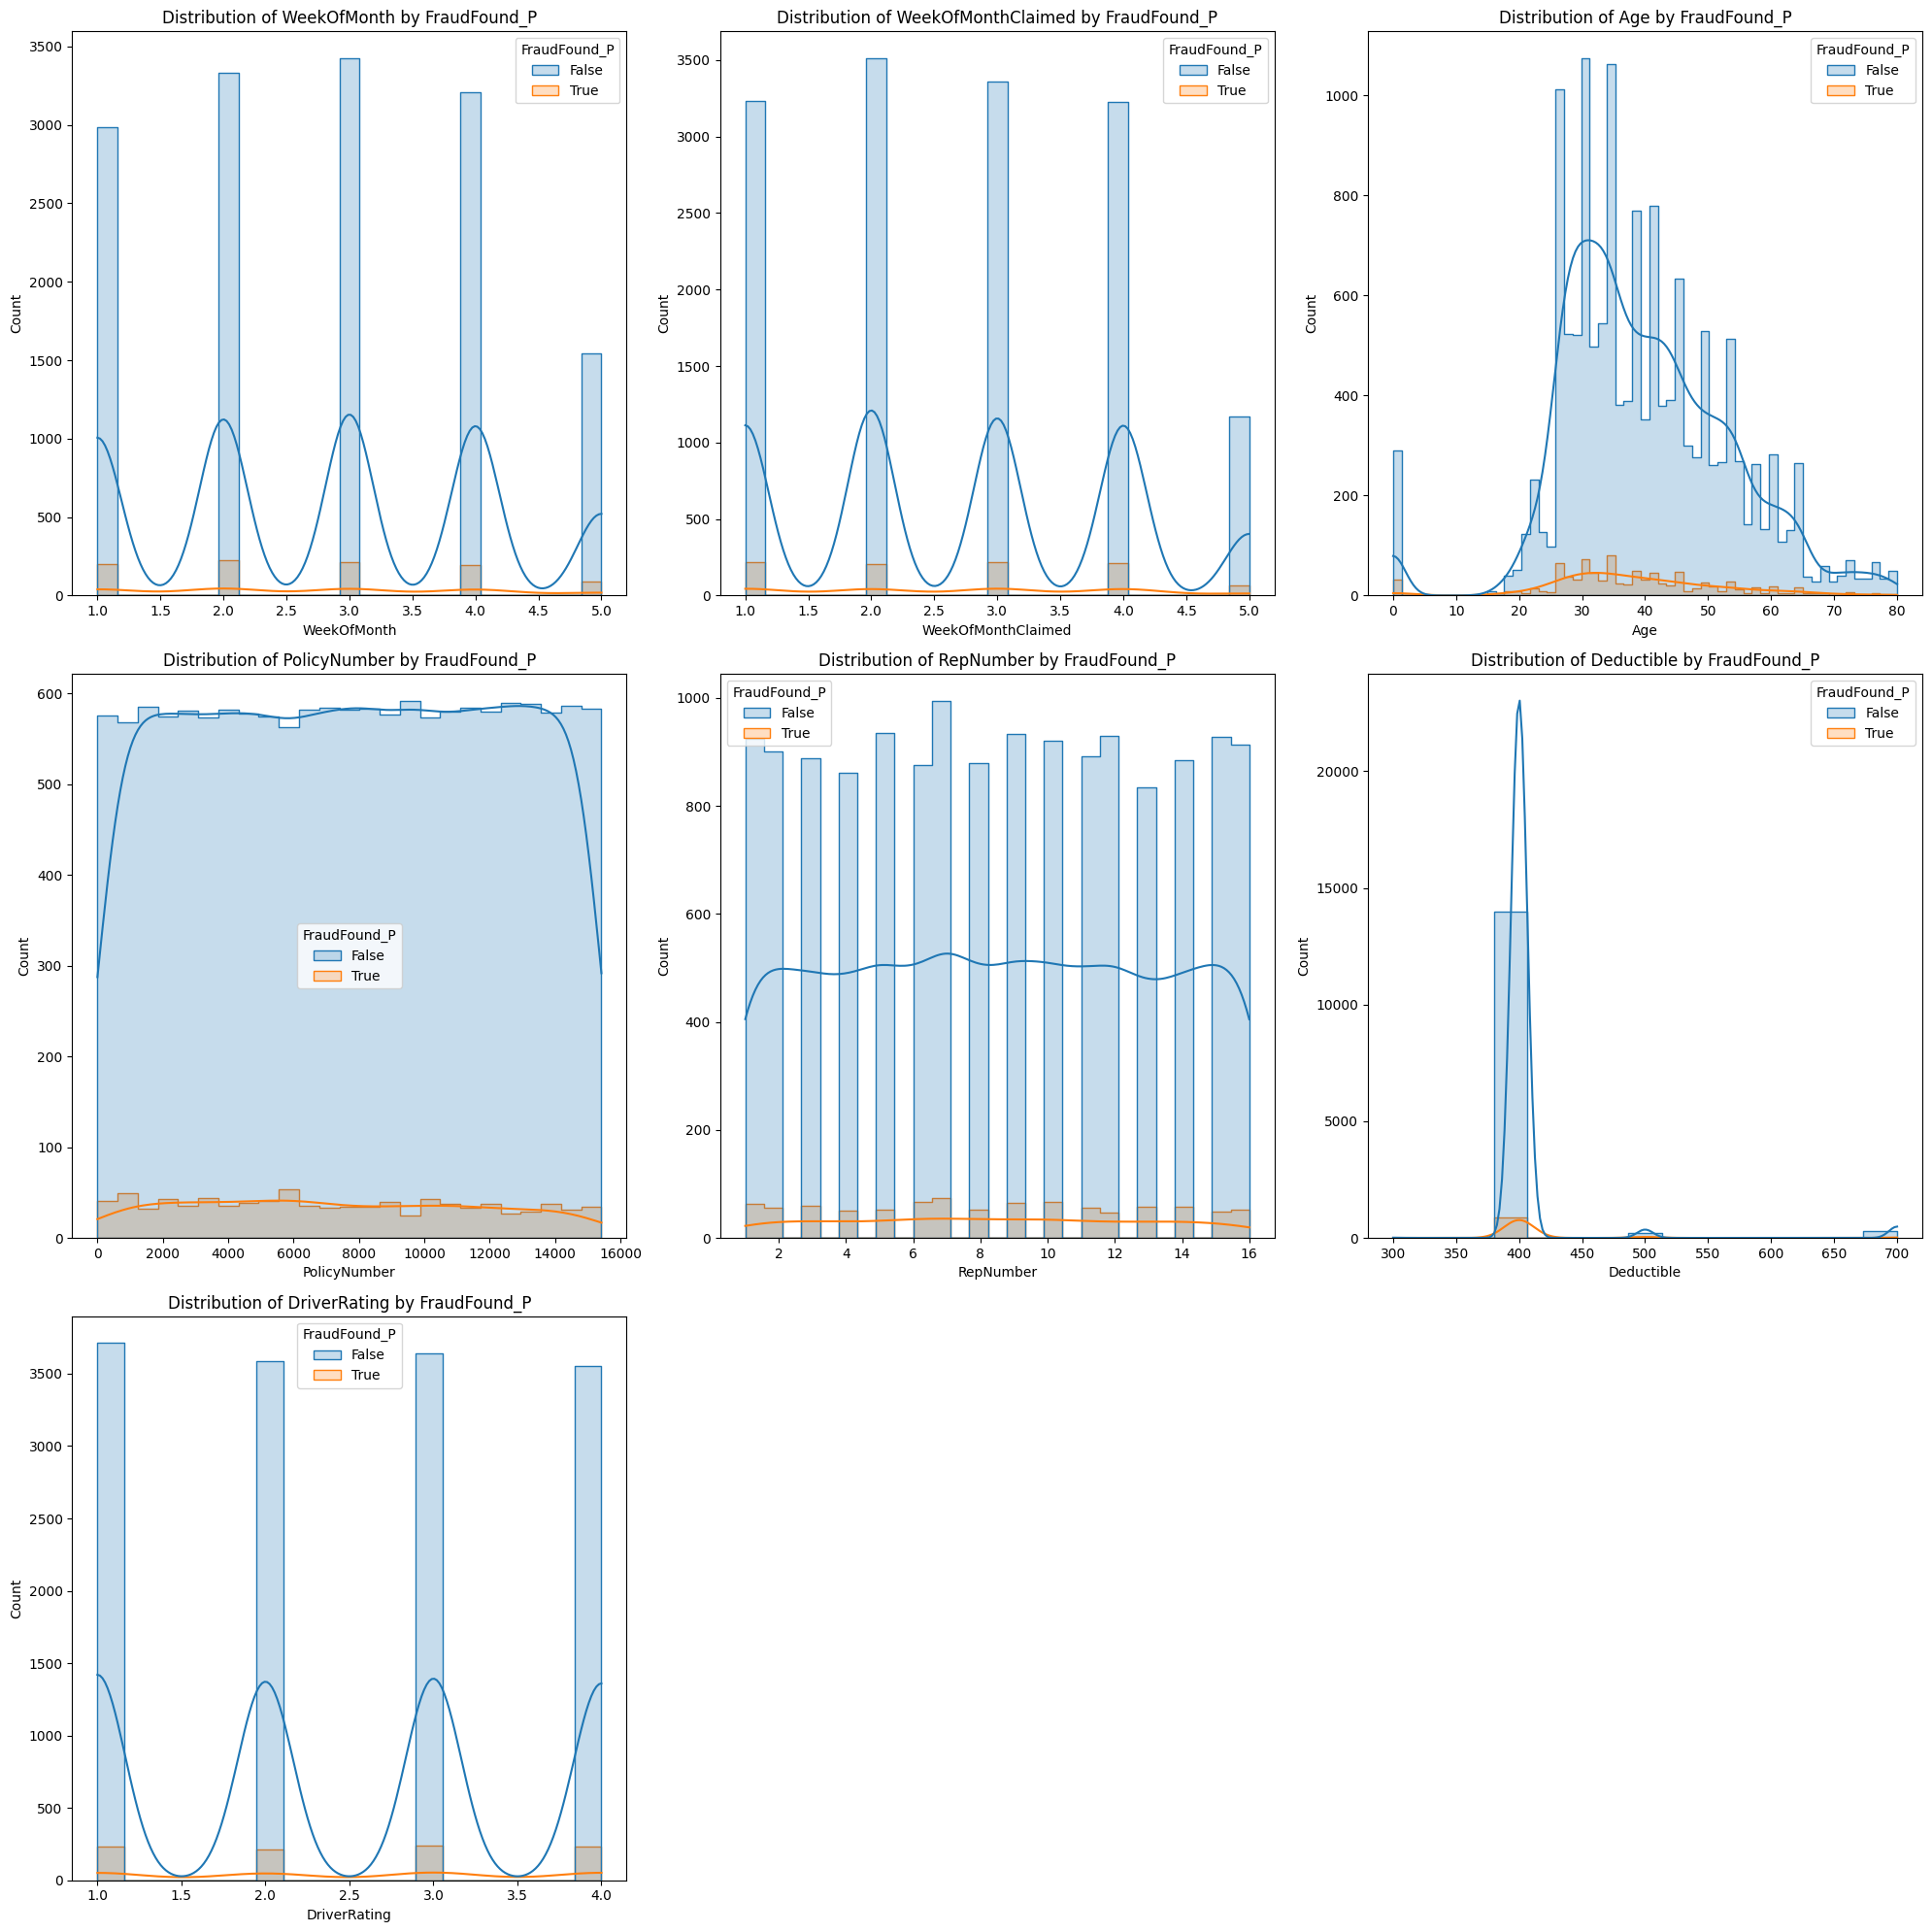

In [18]:
#Plot distribution of numerical features by FraudFound_P
plt.figure(figsize=(20,20))
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

#adjusting the number of plots per row
plots_per_row = 3

for i, col in enumerate(numerical_cols):
    plt.subplot((len(numerical_cols) // plots_per_row) + 1, plots_per_row, i +1)
    sns.histplot(data=df, x=col, hue='FraudFound_P', kde=True, element='step')
    plt.title(f'Distribution of {col} by FraudFound_P')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

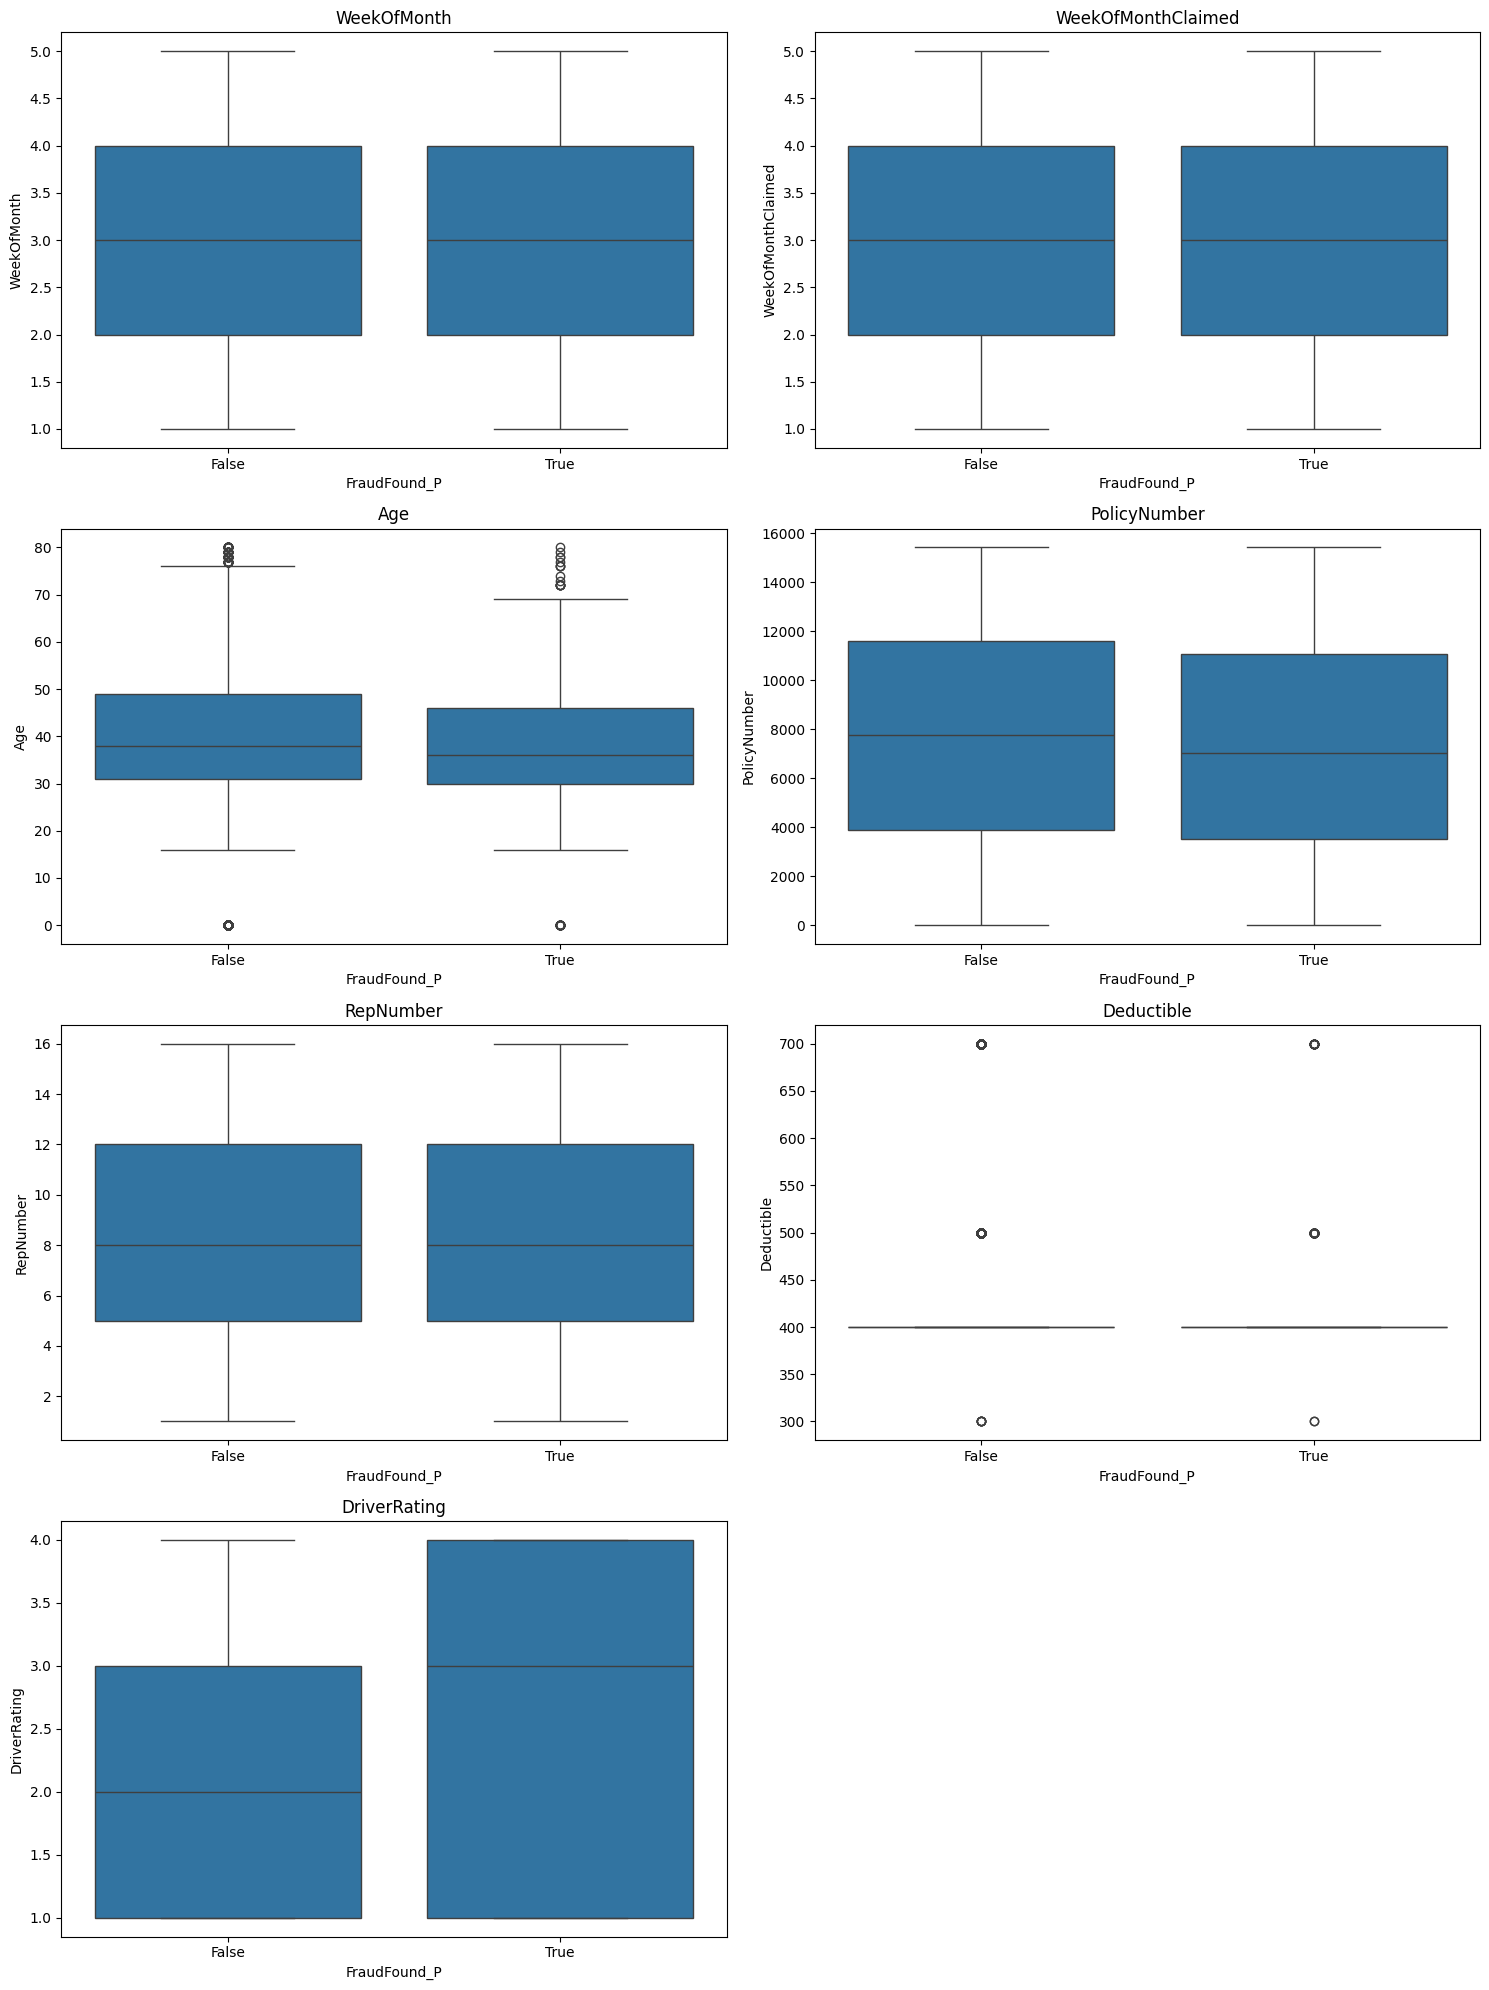

In [19]:
#plot boxplots to check for outliers and their relation with the target variable
plt.figure(figsize=(15,20))
for i, col in enumerate(numerical_cols):
    plt.subplot(4, 2, i+1)
    sns.boxplot(x='FraudFound_P', y=col, data=df)
    plt.title(f'{col}')
plt.tight_layout()
plt.show()

In [20]:
# Outlier removal using IQR for Deductible
Q1 = df['Deductible'].quantile(0.25)
Q3 = df['Deductible'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df_cleaned= df[(df['Deductible'] >= lower) & (df['Deductible'] <= upper)]

print("Original dataset shape:", df.shape)
print("Dataset shape after outlier removal:", df_cleaned.shape)

Original dataset shape: (15420, 33)
Dataset shape after outlier removal: (14838, 33)


In [21]:
#Convert categorical variables to stings to ensure consistent handling
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
df[categorical_cols] = df[categorical_cols].astype(str)
df['FraudFound_P'] = df['FraudFound_P'].astype(str)

#Calculate chi-square statistics and store in a DataFrame
chi2_results = []
for col in categorical_cols:
    contingency_table = pd.crosstab(df[col], df['FraudFound_P'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi2_results.append({'Feature': col, 'chi2':chi2, 'p-value': p, 'Degrees of Freedom':dof})

chi2_df = pd.DataFrame(chi2_results)
chi2_df

,Feature,chi2,p-value,Degrees of Freedom
0,Month,29.796429,1.705480e-03,11
1,DayOfWeek,10.150635,1.184501e-01,6
2,Make,59.809999,2.195889e-06,18
3,AccidentArea,16.844310,4.057480e-05,1
4,DayOfWeekClaimed,5.159623,6.404907e-01,7
5,MonthClaimed,42.266750,3.003256e-05,12
6,Sex,13.489894,2.398518e-04,1
7,MaritalStatus,1.013512,7.979825e-01,3
8,Fault,264.953824,1.428036e-59,1
9,PolicyType,437.401870,1.848256e-89,8


In [22]:
df['FraudFound_P'] = df['FraudFound_P'].replace({'False':0, 'True':1})

df['FraudFound_P'] = df['FraudFound_P'].astype(int)

fradulent =  df[df['FraudFound_P']==1]
non_fradulent =  df[df['FraudFound_P']==0]

numerical_features = ['WeekOfMonth', 'WeekOfMonthClaimed', 'Age', 'PolicyNumber', 'RepNumber', 'Deductible', 'DriverRating']

alpha = 0.05
results = []

for feature in numerical_features:
    t_stat, p_val = stats.ttest_ind(fradulent[feature].dropna(), non_fradulent[feature].dropna())
    result = {
    'Feature': feature,
    'T-statistic': t_stat,
    'p-value': p_val,
    'Significant': p_val < alpha
    }
    results.append(result)
    #print result
    print(f'Feature: {feature}')
    print(f'T-statistic: {t_stat}')
    print(f'p-value: {p_val}')
    if p_val < alpha:
        print("Reject the null hypothesis: There is a significant difference between the two groups. \n")
    else:
        print("Fail to reject the null hypothesis: There is no significant difference between the two groups. \n")

results_df = pd.DataFrame(results)
print(results_df)

Feature: WeekOfMonth
T-statistic: -1.4729342644344183
p-value: 0.14078917523145648
Fail to reject the null hypothesis: There is no significant difference between the two groups. 

Feature: WeekOfMonthClaimed
T-statistic: -0.7153534148245128
p-value: 0.47440152274095515
Fail to reject the null hypothesis: There is no significant difference between the two groups. 

Feature: Age
T-statistic: -3.6945702717175912
p-value: 0.00022102056801804655
Reject the null hypothesis: There is a significant difference between the two groups. 

Feature: PolicyNumber
T-statistic: -2.5267037335650477
p-value: 0.01152377750793551
Reject the null hypothesis: There is a significant difference between the two groups. 

Feature: RepNumber
T-statistic: -0.9376604012363482
p-value: 0.3484336475250911
Fail to reject the null hypothesis: There is no significant difference between the two groups. 

Feature: Deductible
T-statistic: 2.1543955340979646
p-value: 0.031224609090792894
Reject the null hypothesis: There is

processing feature: Month
processing feature: DayOfWeek
processing feature: Make
processing feature: AccidentArea
processing feature: DayOfWeekClaimed
processing feature: MonthClaimed
processing feature: Sex
processing feature: MaritalStatus
processing feature: Fault
processing feature: PolicyType
processing feature: VehicleCategory
processing feature: VehiclePrice
processing feature: Days_Policy_Accident
processing feature: Days_Policy_Claim
processing feature: PastNumberOfClaims
processing feature: AgeOfVehicle
processing feature: AgeOfPolicyHolder
processing feature: PoliceReportFiled
processing feature: WitnessPresent
processing feature: AgentType
processing feature: NumberOfSuppliments
processing feature: AddressChange_Claim
processing feature: NumberOfCars
processing feature: Year
processing feature: BasePolicy


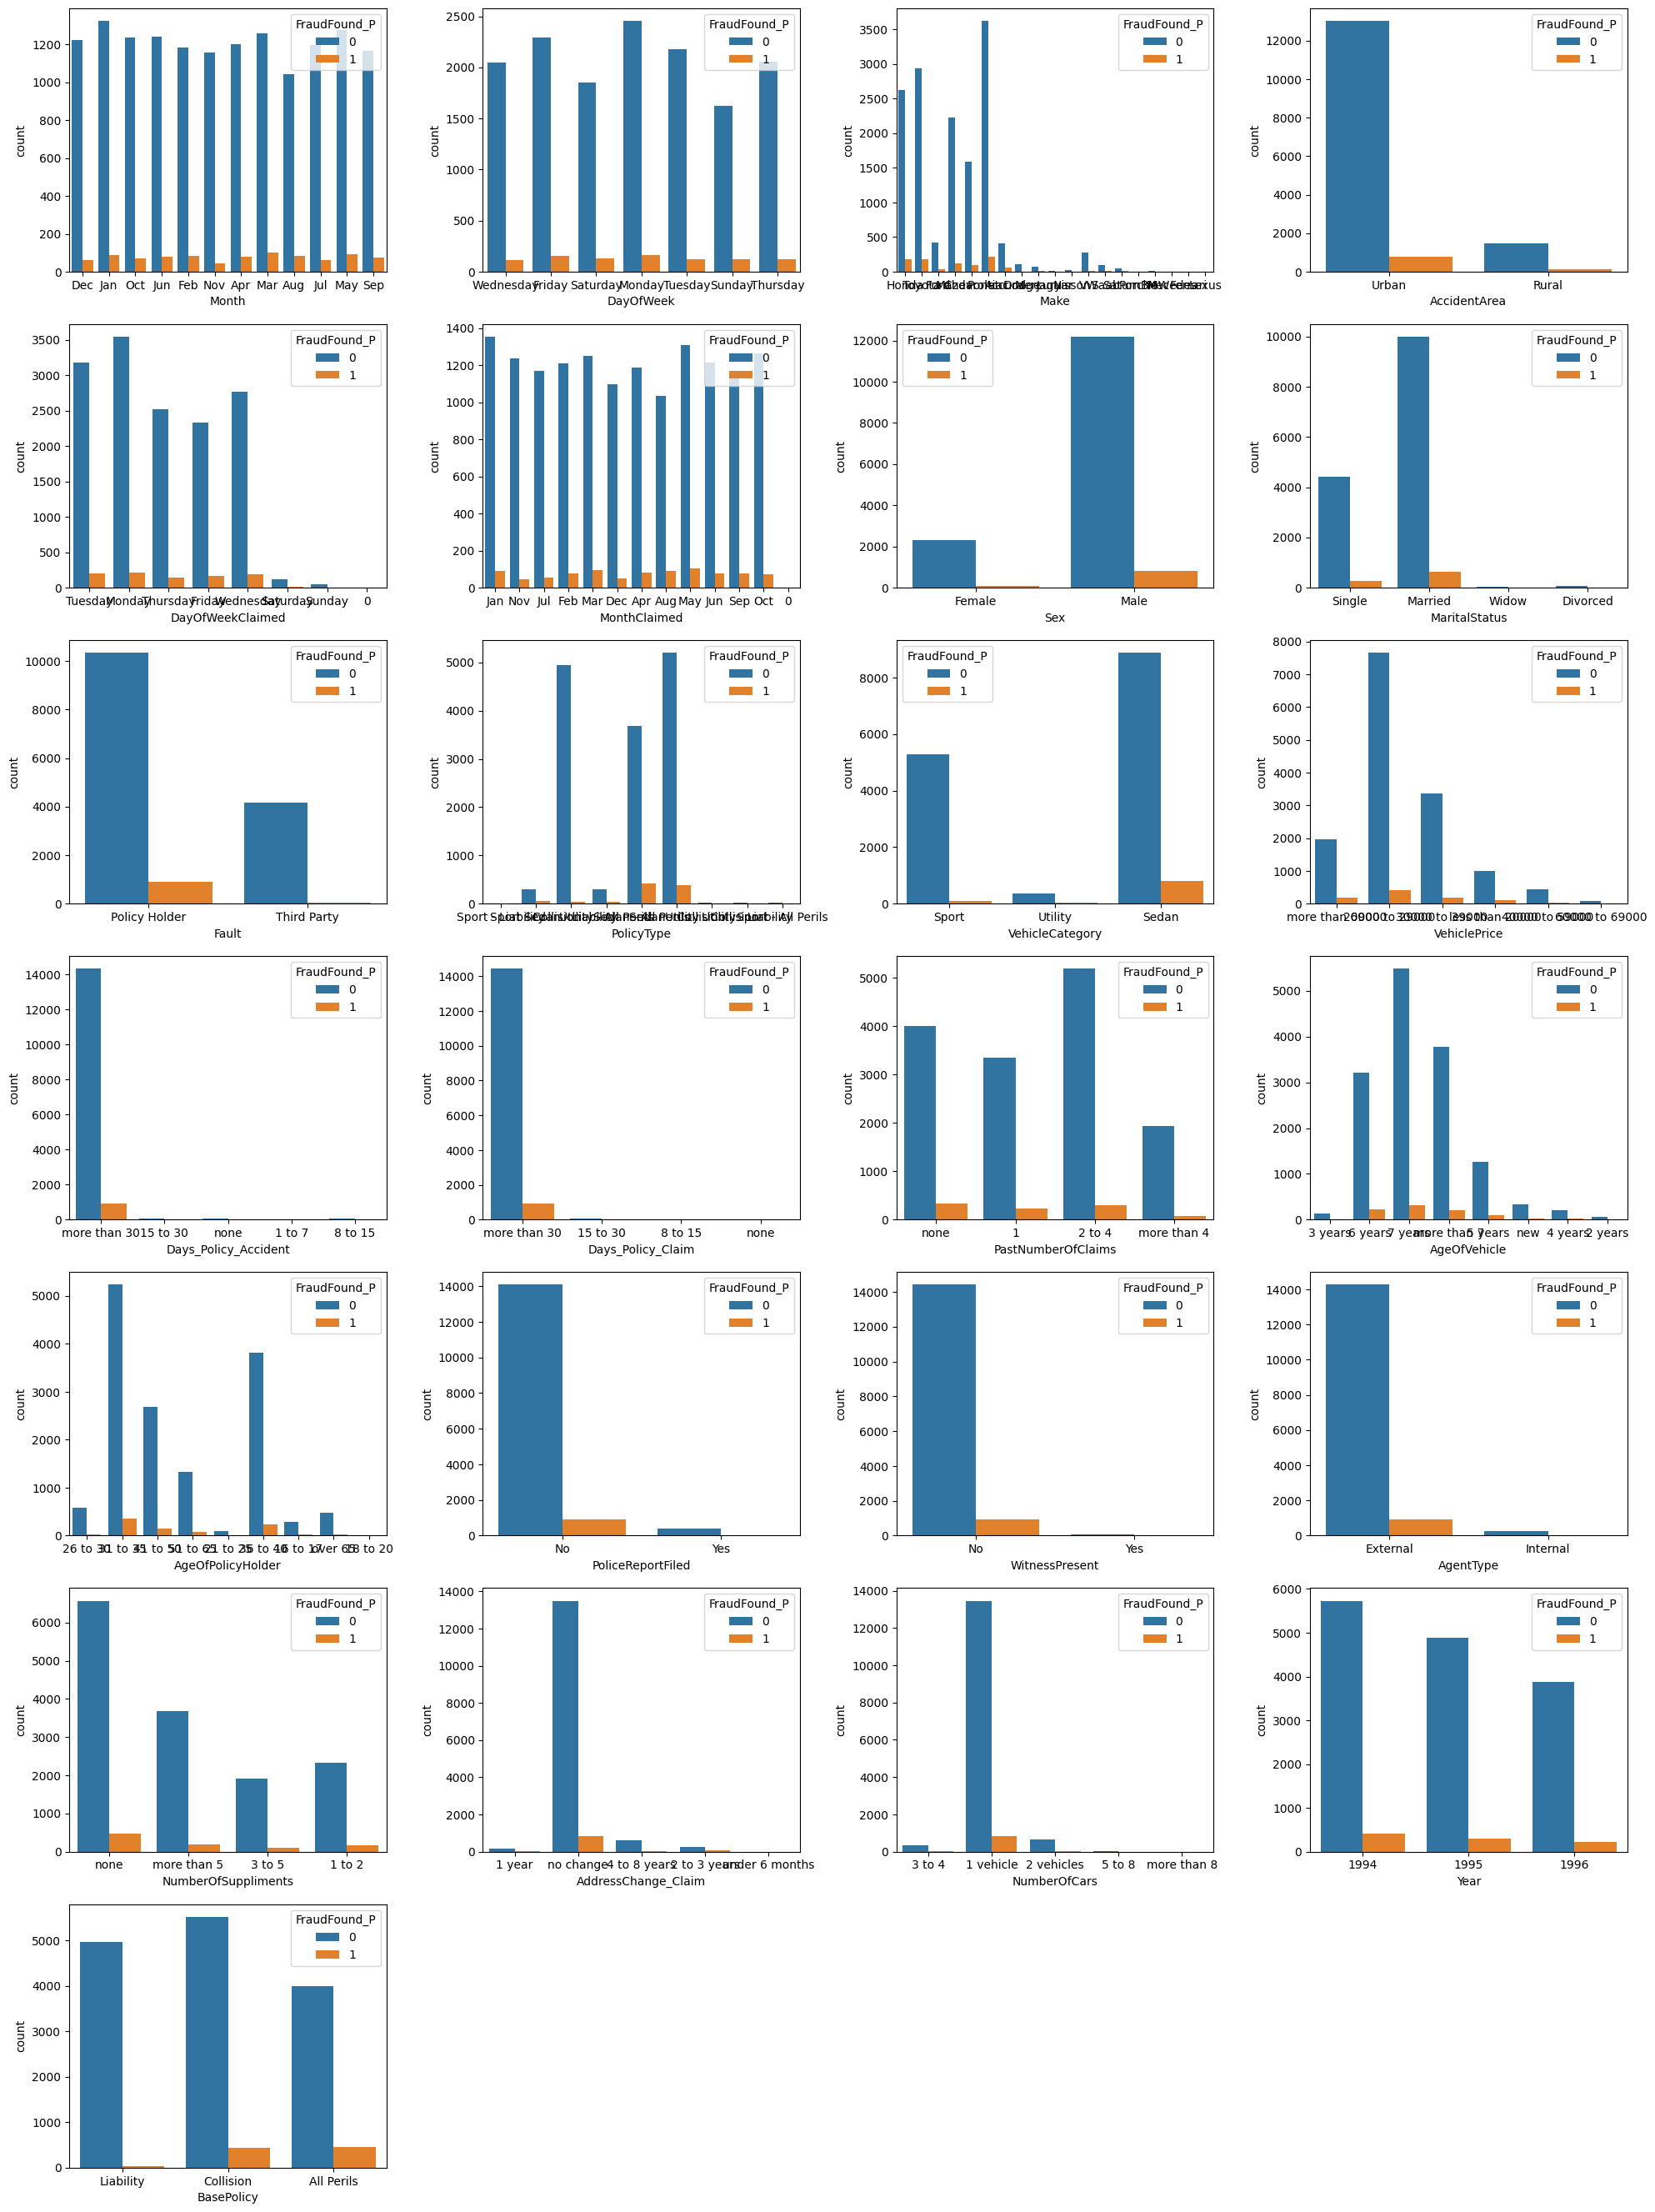

In [23]:
#Plots bar plots for categorical features
plt.figure(figsize=(20,30))
for i, col in enumerate(categorical_cols):
    print(f"processing feature: {col}")
    plt.subplot(8,4, i+1)
    try:
        sns.countplot(x=col, hue='FraudFound_P', data=df)

        p_value_row = chi2_df.loc[chi2_df['Feature'] == col]
        if not p_value_row.empty:
            p_value = p_value_row['p_value'].values[0]
            plt.title(f'Distribution of {col} by FraudFound_P\n(p-value: {p_value: .4f})')
        else:
            plt.title(f'Distributio of {col} by FraudFound_P\n(p-value: N/A)')

            plt.xticks(rotation =90)
    except Exception as e:
            #print("Error processing feature {col}: {e}")
            pass
plt.tight_layout()
plt.show()

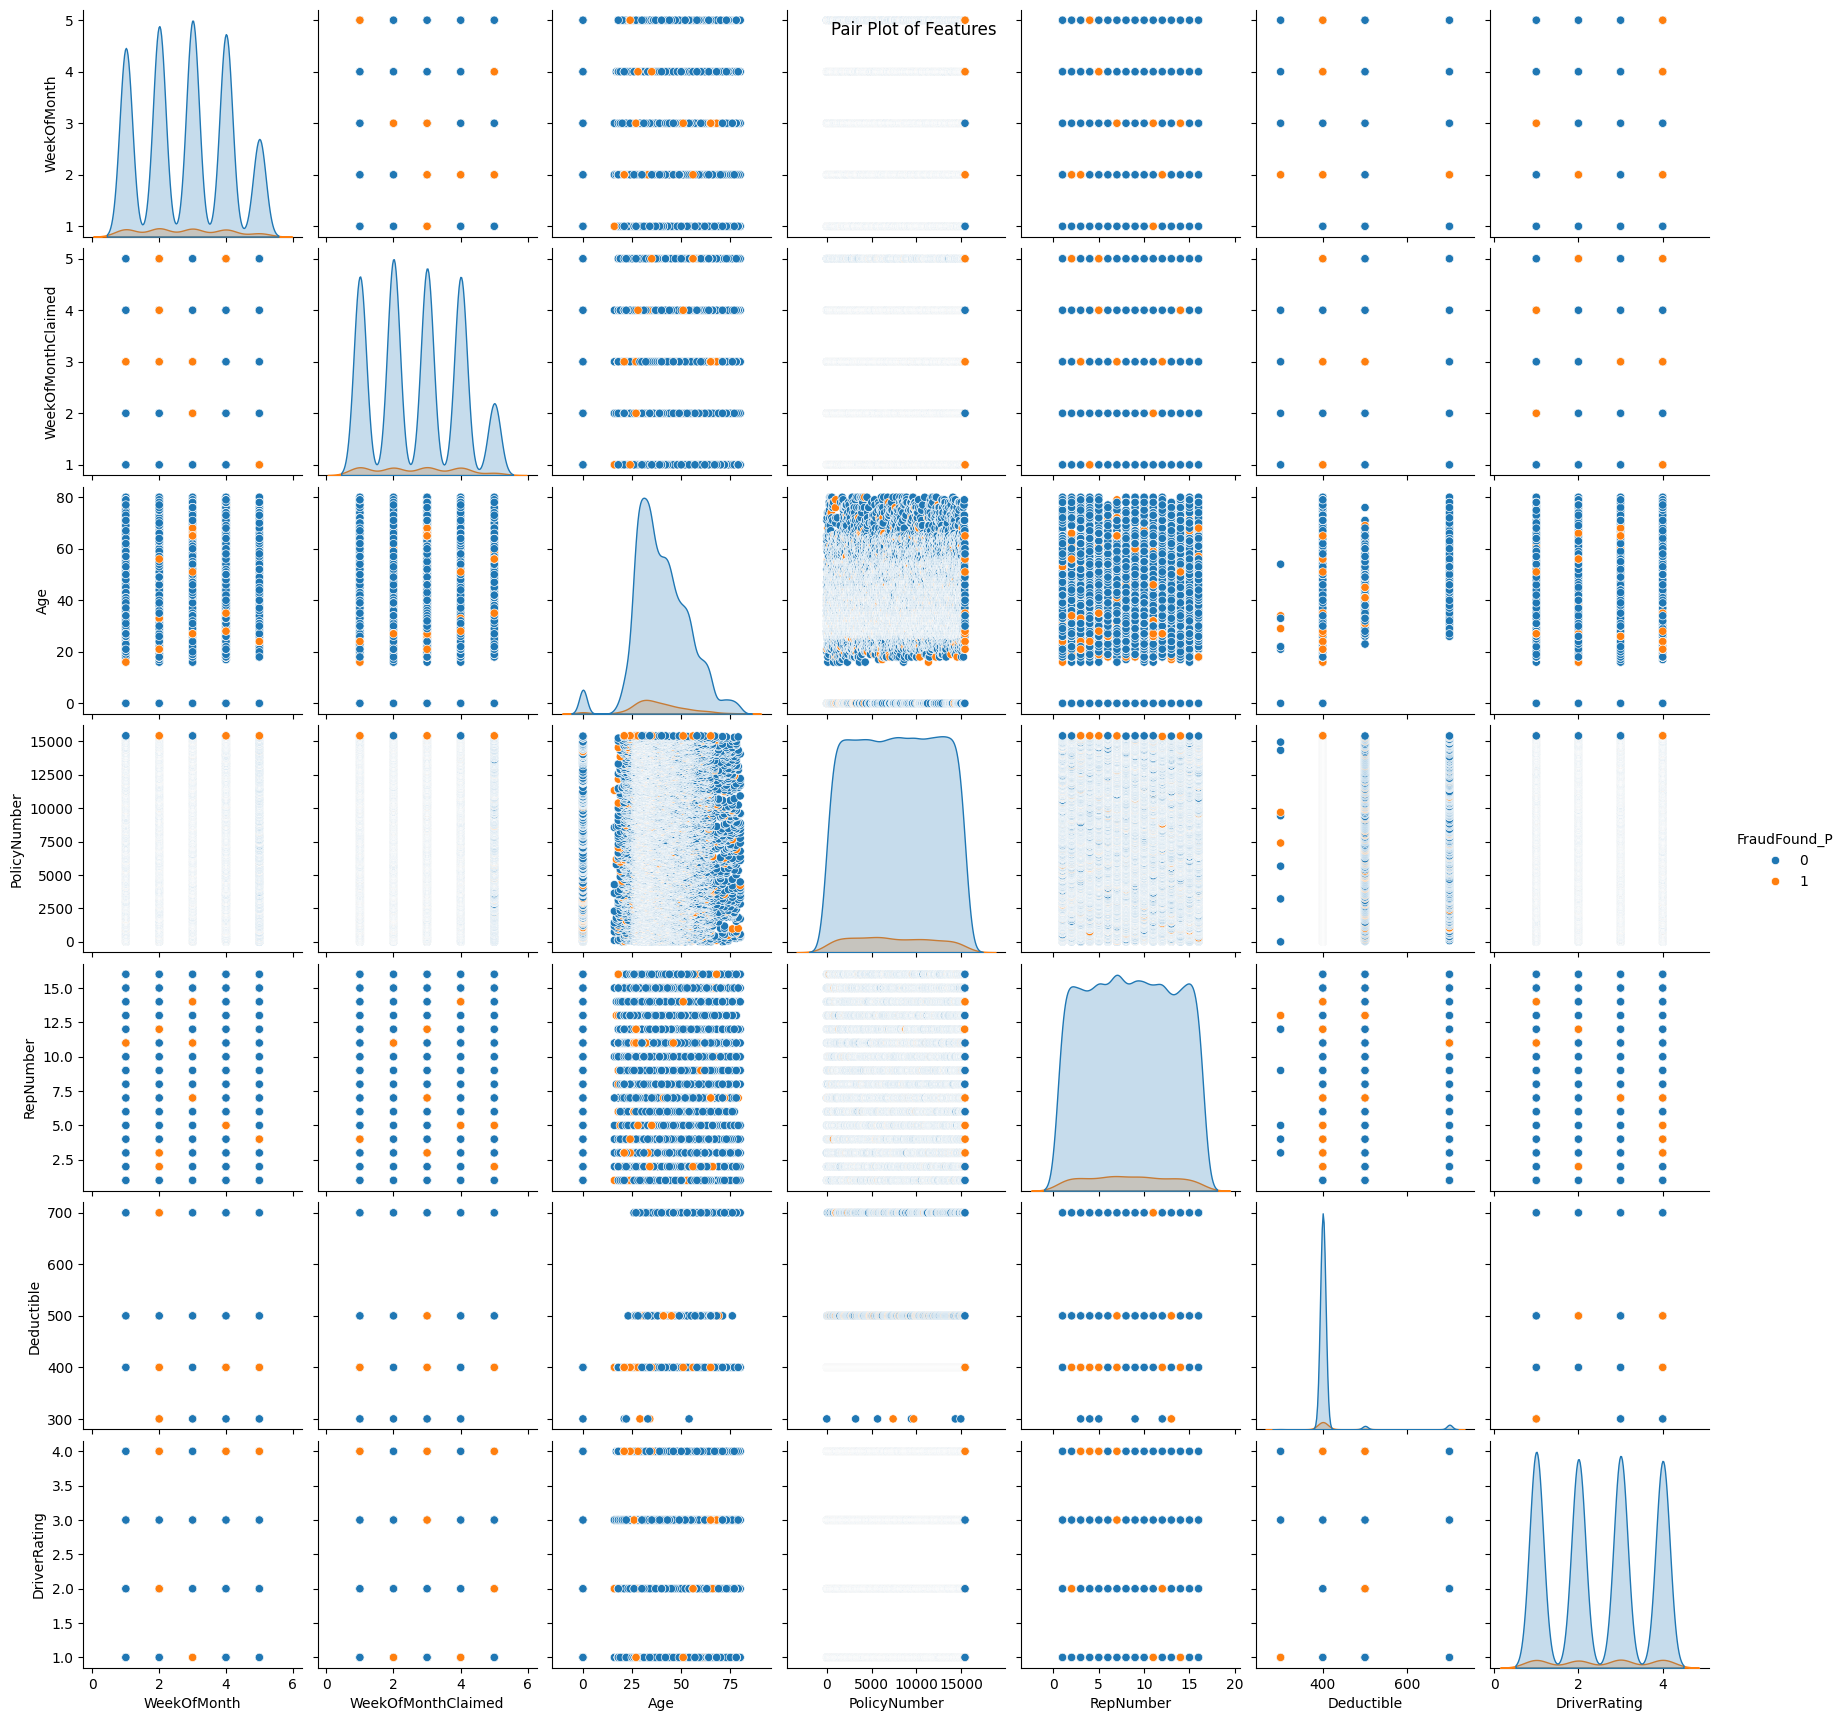

In [24]:
sns.pairplot(df, hue='FraudFound_P', diag_kind='kde')
plt.suptitle('Pair Plot of Features')
plt.show()

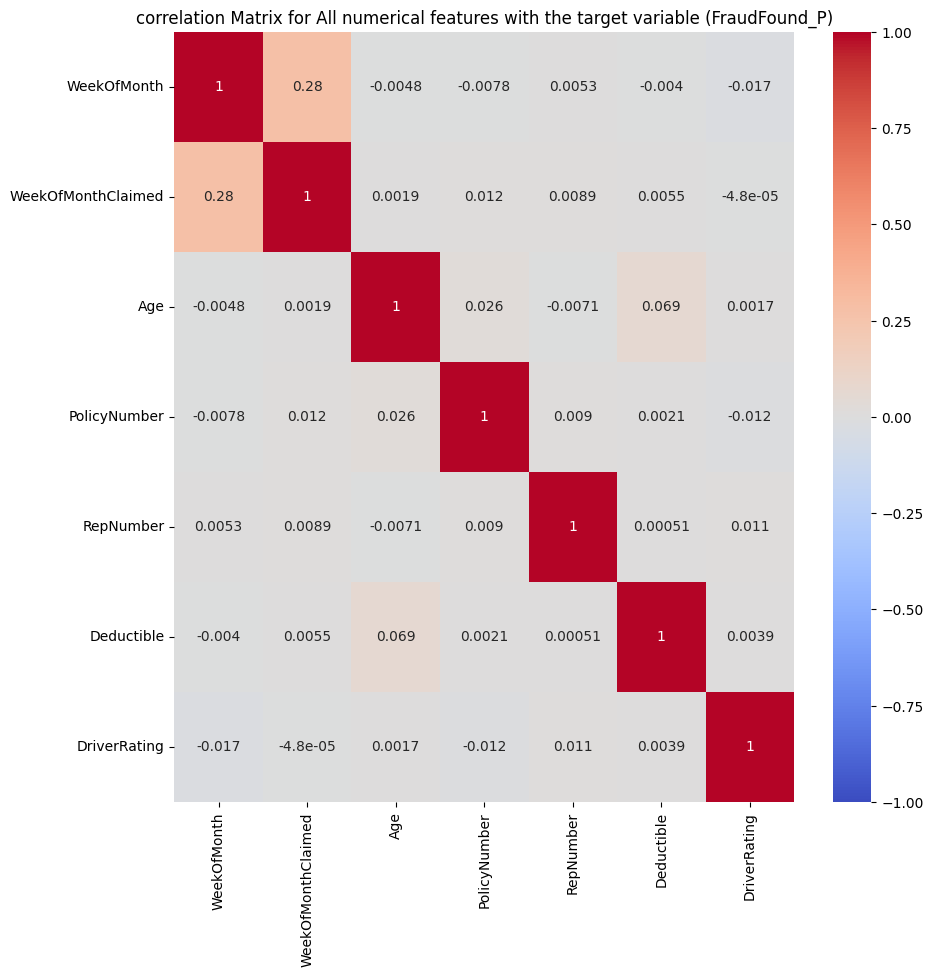

In [25]:
corr_matrix = df[numerical_cols].corr()

plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm',vmin=-1,vmax=1)
plt.title('correlation Matrix for All numerical features with the target variable (FraudFound_P)')
plt.show()

##Feature Engineering


In [26]:
df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [27]:
#feature extarction from EDA and Domain Knowledge

columns_of_interest = [
    'FraudFound_P',
    'AgeOfVehicle',
    'AgeOfPolicyHolder',
    'PastNumberOfClaims',
    'VehiclePrice',
    'VehicleCategory',
    'BasePolicy',
    'Fault',
    'Deductible',
    'PolicyType',
    'Sex'
]

df_relevant = df[columns_of_interest]

df_relevant.head()


,FraudFound_P,AgeOfVehicle,AgeOfPolicyHolder,PastNumberOfClaims,VehiclePrice,VehicleCategory,BasePolicy,Fault,Deductible,PolicyType,Sex
0,0,3 years,26 to 30,none,more than 69000,Sport,Liability,Policy Holder,300,Sport - Liability,Female
1,0,6 years,31 to 35,none,more than 69000,Sport,Collision,Policy Holder,400,Sport - Collision,Male
2,0,7 years,41 to 50,1,more than 69000,Sport,Collision,Policy Holder,400,Sport - Collision,Male
3,0,more than 7,51 to 65,1,20000 to 29000,Sport,Liability,Third Party,400,Sedan - Liability,Male
4,0,5 years,31 to 35,none,more than 69000,Sport,Collision,Third Party,400,Sport - Collision,Female


In [28]:
df_encoded = pd.get_dummies(df_relevant, drop_first=True)
df_encoded = df_encoded.applymap(lambda x: 1 if x is True else (0 if x is False else x))
df_encoded = df_encoded.map(lambda x: 1if x is True else (0 if x is False else x))

df_encoded.head()

<>:3: SyntaxWarning: invalid decimal literal
<>:3: SyntaxWarning: invalid decimal literal
/tmp/ipython-input-28-1587585562.py:3: SyntaxWarning: invalid decimal literal
  df_encoded = df_encoded.map(lambda x: 1if x is True else (0 if x is False else x))


,FraudFound_P,Deductible,AgeOfVehicle_3 years,AgeOfVehicle_4 years,AgeOfVehicle_5 years,AgeOfVehicle_6 years,AgeOfVehicle_7 years,AgeOfVehicle_more than 7,AgeOfVehicle_new,AgeOfPolicyHolder_18 to 20,...,Fault_Third Party,PolicyType_Sedan - Collision,PolicyType_Sedan - Liability,PolicyType_Sport - All Perils,PolicyType_Sport - Collision,PolicyType_Sport - Liability,PolicyType_Utility - All Perils,PolicyType_Utility - Collision,PolicyType_Utility - Liability,Sex_Male
0,0,300,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,400,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0,400,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0,400,0,0,0,0,0,1,0,0,...,1,0,1,0,0,0,0,0,0,1
4,0,400,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0


In [29]:
scaler = StandardScaler()
df_encoded['Deductible'] = scaler.fit_transform(df_encoded['Deductible'].values.reshape(-1,1))

df_encoded.head()

,FraudFound_P,Deductible,AgeOfVehicle_3 years,AgeOfVehicle_4 years,AgeOfVehicle_5 years,AgeOfVehicle_6 years,AgeOfVehicle_7 years,AgeOfVehicle_more than 7,AgeOfVehicle_new,AgeOfPolicyHolder_18 to 20,...,Fault_Third Party,PolicyType_Sedan - Collision,PolicyType_Sedan - Liability,PolicyType_Sport - All Perils,PolicyType_Sport - Collision,PolicyType_Sport - Liability,PolicyType_Utility - All Perils,PolicyType_Utility - Collision,PolicyType_Utility - Liability,Sex_Male
0,0,-2.450633,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,-0.175298,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0,-0.175298,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0,-0.175298,0,0,0,0,0,1,0,0,...,1,0,1,0,0,0,0,0,0,1
4,0,-0.175298,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0


In [30]:
#pulling out the target variable

target_col = df_encoded['FraudFound_P'].copy()
target_col.head()

,FraudFound_P
0,0
1,0
2,0
3,0
4,0


In [31]:
#Applying SMOTE to and balance the data

X = df_encoded.drop(columns=['FraudFound_P'])
y= df_encoded['FraudFound_P']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X,y)

df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['FraudFound_P'] = y_resampled

df_resampled.head()
X.head()

,Deductible,AgeOfVehicle_3 years,AgeOfVehicle_4 years,AgeOfVehicle_5 years,AgeOfVehicle_6 years,AgeOfVehicle_7 years,AgeOfVehicle_more than 7,AgeOfVehicle_new,AgeOfPolicyHolder_18 to 20,AgeOfPolicyHolder_21 to 25,...,Fault_Third Party,PolicyType_Sedan - Collision,PolicyType_Sedan - Liability,PolicyType_Sport - All Perils,PolicyType_Sport - Collision,PolicyType_Sport - Liability,PolicyType_Utility - All Perils,PolicyType_Utility - Collision,PolicyType_Utility - Liability,Sex_Male
0,-2.450633,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,-0.175298,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,-0.175298,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,-0.175298,0,0,0,0,0,1,0,0,0,...,1,0,1,0,0,0,0,0,0,1
4,-0.175298,0,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0


In [32]:
#splitting the data

X_train, X_test, y_train, y_test = train_test_split(df_resampled.drop(columns=['FraudFound_P']),df_resampled['FraudFound_P'],test_size=0.2, random_state=42)

In [33]:
results = []

## Models

In [34]:
log_reg = LogisticRegression(random_state= 42)
log_reg.fit(X_train, y_train)

y_pred_log_reg = log_reg.predict(X_test)
print("Logistic Regression:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg)}")
print(classification_report(y_test,y_pred_log_reg))
print(confusion_matrix(y_test, y_pred_log_reg))

Logistic Regression:
Accuracy: 0.7927228832557337
              precision    recall  f1-score   support

           0       0.87      0.69      0.77      2899
           1       0.74      0.90      0.81      2900

    accuracy                           0.79      5799
   macro avg       0.81      0.79      0.79      5799
weighted avg       0.81      0.79      0.79      5799

[[2001  898]
 [ 304 2596]]


#Hyperparameter tuning for linear regression

In [35]:
log_reg = LogisticRegression(random_state= 42, class_weight='balanced', max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred_log_reg = log_reg.predict(X_test)
print("Logistic Regression with class weights:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg)}")
print(classification_report(y_test,y_pred_log_reg))
print(confusion_matrix(y_test, y_pred_log_reg))

Logistic Regression with class weights:
Accuracy: 0.7927228832557337
              precision    recall  f1-score   support

           0       0.87      0.69      0.77      2899
           1       0.74      0.90      0.81      2900

    accuracy                           0.79      5799
   macro avg       0.81      0.79      0.79      5799
weighted avg       0.81      0.79      0.79      5799

[[2001  898]
 [ 304 2596]]


In [36]:
log_reg = LogisticRegression(random_state=42, max_iter=2000)
log_reg.fit(X_train, y_train)

y_pred_log_reg = log_reg.predict(X_test)
print("Logistic Regression:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg)}")
print(classification_report(y_test,y_pred_log_reg))
print(confusion_matrix(y_test, y_pred_log_reg))

Logistic Regression:
Accuracy: 0.7927228832557337
              precision    recall  f1-score   support

           0       0.87      0.69      0.77      2899
           1       0.74      0.90      0.81      2900

    accuracy                           0.79      5799
   macro avg       0.81      0.79      0.79      5799
weighted avg       0.81      0.79      0.79      5799

[[2001  898]
 [ 304 2596]]


In [37]:
param_grid = {
    'C': [0.1,1,10,100],
    'solver': ['newton-cg', 'Ibfgs', 'liblinear'],
    'class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(LogisticRegression(random_state=42,max_iter=1000), param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

print("Best parameters for logistic regression:", grid_search.best_params_)
best_log_reg = grid_search.best_estimator_
y_pred_best_log_reg = best_log_reg.predict(X_test)

print("Tuned Logistic Regression:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best_log_reg)}")
print(classification_report(y_test, y_pred_best_log_reg))
print(confusion_matrix(y_test, y_pred_best_log_reg))

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
40 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/

Best parameters for logistic regression: {'C': 1, 'class_weight': None, 'solver': 'newton-cg'}
Tuned Logistic Regression:
Accuracy: 0.7928953267804794
              precision    recall  f1-score   support

           0       0.87      0.69      0.77      2899
           1       0.74      0.90      0.81      2900

    accuracy                           0.79      5799
   macro avg       0.81      0.79      0.79      5799
weighted avg       0.81      0.79      0.79      5799

[[2001  898]
 [ 303 2597]]


The tuned Linear Regression model had insignificant improvement

In [38]:
report = classification_report(y_test, y_pred_best_log_reg, output_dict=True)
precision = report['1']['precision']
recall = report['1']['recall']
f1_score_value = report['1']['f1-score']
accuracy = report['accuracy']

results.append({
    "name": "Linear Regression Model",
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1_score_value
})

print(results)

[{'name': 'Linear Regression Model', 'accuracy': 0.7928953267804794, 'precision': 0.7430615164520744, 'recall': 0.8955172413793103, 'f1_score': 0.8121970289288507}]


In [39]:
#Train Isolation Forest Model

isolation_forest = IsolationForest(contamination=0.06, random_state = 42)
isolation_forest.fit(X_train)
y_pred_if = isolation_forest.predict(X_test)
y_pred_if = [1 if x == -1 else 0 for x in y_pred_if]

#Evvaluate Isolation Forest Model
print("Isolation Forest:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_if)}")
print(classification_report(y_test, y_pred_if))
print(confusion_matrix(y_test, y_pred_if))

Isolation Forest:
Accuracy: 0.45507846180375927
              precision    recall  f1-score   support

           0       0.48      0.89      0.62      2899
           1       0.13      0.02      0.03      2900

    accuracy                           0.46      5799
   macro avg       0.30      0.46      0.33      5799
weighted avg       0.30      0.46      0.33      5799

[[2592  307]
 [2853   47]]


# Hyperparameter Tuning for Isolation Forest Model

In [40]:
#Define a custom  scoring function that fits the nature of the problem
def anomaly_score(y_true, y_pred):
    y_pred = [1 if x == -1 else 0 for x in y_pred]
    return f1_score(y_true, y_pred)

scorer = make_scorer(anomaly_score, greater_is_better=True)

param_distributions_if = {
    'n_estimators': [50,100,150],
    'max_samples': ['auto', 0.8,0.9],
    'contamination': [0.05, 0.06,0.07],
    'max_features': [1.0, 0.8, 0.9]
}

#Initialize RandomizedSearchCV
random_search_if = RandomizedSearchCV(IsolationForest(random_state=42), param_distributions_if, n_iter=20, cv=5, scoring= scorer, random_state= 42, n_jobs =-1)

#Fit to the training data
random_search_if.fit(X_train, y_train)

#Best parameters and evaluation
print("Best parameters for Isolation Forest:", random_search_if.best_params_)
best_if = random_search_if.best_estimator_
y_pred_if_best = best_if.predict(X_test)
y_pred_if_best = [ 1 if x == -1 else 0 for x in y_pred_if_best]

print("Tuned Isolation Forest:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_if_best)}")
print(classification_report(y_test, y_pred_if_best))
print(confusion_matrix(y_test, y_pred_if_best))

Best parameters for Isolation Forest: {'n_estimators': 50, 'max_samples': 'auto', 'max_features': 0.9, 'contamination': 0.06}
Tuned Isolation Forest:
Accuracy: 0.4752543541989998
              precision    recall  f1-score   support

           0       0.49      0.92      0.64      2899
           1       0.30      0.04      0.06      2900

    accuracy                           0.48      5799
   macro avg       0.39      0.48      0.35      5799
weighted avg       0.39      0.48      0.35      5799

[[2653  246]
 [2797  103]]


In [41]:
report = classification_report(y_test, y_pred_if_best, output_dict=True)
precision = report['1']['precision']
recall = report['1']['recall']
f1_score_value = report['1']['f1-score']
accuracy = report['accuracy']

results.append({
    "name": "Isolation Forest Model",
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1_score_value
})

print(results)

[{'name': 'Linear Regression Model', 'accuracy': 0.7928953267804794, 'precision': 0.7430615164520744, 'recall': 0.8955172413793103, 'f1_score': 0.8121970289288507}, {'name': 'Isolation Forest Model', 'accuracy': 0.4752543541989998, 'precision': 0.29512893982808025, 'recall': 0.035517241379310345, 'f1_score': 0.0634041243459526}]


In [42]:
#Define the gradient boosting model

gb_model = GradientBoostingClassifier(random_state=42)

#Fit the model to the training data
gb_model.fit(X_train, y_train)

#Predict on the texst data
y_pred_gb = gb_model.predict(X_test)

print("Gradient Boosting:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb)}")
print(classification_report(y_test, y_pred_gb))
print(confusion_matrix(y_test, y_pred_gb))

Gradient Boosting:
Accuracy: 0.804793929987929
              precision    recall  f1-score   support

           0       0.92      0.66      0.77      2899
           1       0.74      0.95      0.83      2900

    accuracy                           0.80      5799
   macro avg       0.83      0.80      0.80      5799
weighted avg       0.83      0.80      0.80      5799

[[1926  973]
 [ 159 2741]]


In [43]:
param_grid_gb = {
    'n_estimators': [50,100,150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

#Initialize RandomizedSearchCV
grid_search_gb = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gb, cv=3, scoring= 'accuracy')

#Fit to the training data
grid_search_gb.fit(X_train, y_train)

#Best parameters and evaluation
print("Best parameters for Gradient Boosting:", grid_search_gb.best_params_)
best_gb = grid_search_gb.best_estimator_
y_pred_gb_best = best_gb.predict(X_test)

print("Tuned Gradient Boosting:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb_best)}")
print(classification_report(y_test, y_pred_gb_best))
print(confusion_matrix(y_test, y_pred_gb_best))

Best parameters for Gradient Boosting: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150}
Tuned Gradient Boosting:
Accuracy: 0.8535954474909467
              precision    recall  f1-score   support

           0       0.94      0.76      0.84      2899
           1       0.80      0.95      0.87      2900

    accuracy                           0.85      5799
   macro avg       0.87      0.85      0.85      5799
weighted avg       0.87      0.85      0.85      5799

[[2194  705]
 [ 144 2756]]


In [44]:
report = classification_report(y_test, y_pred_gb_best, output_dict=True)
precision = report['1']['precision']
recall = report['1']['recall']
f1_score_value = report['1']['f1-score']
accuracy = report['accuracy']

results.append({
    "name": "Gradient Boosting Model",
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1_score_value
})

print(results)

[{'name': 'Linear Regression Model', 'accuracy': 0.7928953267804794, 'precision': 0.7430615164520744, 'recall': 0.8955172413793103, 'f1_score': 0.8121970289288507}, {'name': 'Isolation Forest Model', 'accuracy': 0.4752543541989998, 'precision': 0.29512893982808025, 'recall': 0.035517241379310345, 'f1_score': 0.0634041243459526}, {'name': 'Gradient Boosting Model', 'accuracy': 0.8535954474909467, 'precision': 0.7963016469228547, 'recall': 0.9503448275862069, 'f1_score': 0.8665304197453231}]


In [45]:
X#Define the decision tree model
dt_model = DecisionTreeClassifier(random_state= 42)

#Fit the model to the training data
dt_model.fit(X_train, y_train)

#Predict on the texst data
y_pred_dt = dt_model.predict(X_test)

print("Decision Tree:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt)}")
print(classification_report(y_test, y_pred_dt))
print(confusion_matrix(y_test, y_pred_dt))

Decision Tree:
Accuracy: 0.8522158992929816
              precision    recall  f1-score   support

           0       0.92      0.77      0.84      2899
           1       0.80      0.94      0.86      2900

    accuracy                           0.85      5799
   macro avg       0.86      0.85      0.85      5799
weighted avg       0.86      0.85      0.85      5799

[[2226  673]
 [ 184 2716]]


##Hyperparameter Tuning for Decision Tree Classifier

In [46]:
param_grid_dt = {
    'max_depth': [None,10, 20,30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

#Initialize RandomizedSearchCV
grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=3, scoring= 'accuracy')

#Fit to the training data
grid_search_dt.fit(X_train, y_train)

#Best parameters and evaluation
print("Best parameters for Decision Tree:", grid_search_dt.best_params_)
best_dt = grid_search_dt.best_estimator_
y_pred_dt_best = best_dt.predict(X_test)

print("Tuned Decision Tree:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt_best)}")
print(classification_report(y_test, y_pred_dt_best))
print(confusion_matrix(y_test, y_pred_dt_best))

Best parameters for Decision Tree: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Tuned Decision Tree:
Accuracy: 0.8522158992929816
              precision    recall  f1-score   support

           0       0.92      0.77      0.84      2899
           1       0.80      0.94      0.86      2900

    accuracy                           0.85      5799
   macro avg       0.86      0.85      0.85      5799
weighted avg       0.86      0.85      0.85      5799

[[2226  673]
 [ 184 2716]]


In [47]:
report = classification_report(y_test, y_pred_dt_best, output_dict=True)
precision = report['1']['precision']
recall = report['1']['recall']
f1_score_value = report['1']['f1-score']
accuracy = report['accuracy']

results.append({
    "name": "Decision Tree Classifier Model",
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1_score_value
})

print(results)

[{'name': 'Linear Regression Model', 'accuracy': 0.7928953267804794, 'precision': 0.7430615164520744, 'recall': 0.8955172413793103, 'f1_score': 0.8121970289288507}, {'name': 'Isolation Forest Model', 'accuracy': 0.4752543541989998, 'precision': 0.29512893982808025, 'recall': 0.035517241379310345, 'f1_score': 0.0634041243459526}, {'name': 'Gradient Boosting Model', 'accuracy': 0.8535954474909467, 'precision': 0.7963016469228547, 'recall': 0.9503448275862069, 'f1_score': 0.8665304197453231}, {'name': 'Decision Tree Classifier Model', 'accuracy': 0.8522158992929816, 'precision': 0.8014163470050162, 'recall': 0.9365517241379311, 'f1_score': 0.8637303227858165}]


In [48]:
#Define the XGBoost Model
xgb_model = XGBClassifier(random_state= 42, use_label_encoder=False, eval_metric='mlogloss')

#Fit the model to the training data
xgb_model.fit(X_train, y_train)

#Predict on the texst data
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Model:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb)}")
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:36:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Model:
Accuracy: 0.8429039489567167
              precision    recall  f1-score   support

           0       0.93      0.74      0.83      2899
           1       0.79      0.94      0.86      2900

    accuracy                           0.84      5799
   macro avg       0.86      0.84      0.84      5799
weighted avg       0.86      0.84      0.84      5799

[[2155  744]
 [ 167 2733]]


# Hyperparameter Tuning for XGBoost

In [49]:
param_space = {
    'n_estimators': [50, 300],
    'learning_rate': [0.01, 0.2, 'log-uniform'],
    'max_depth': [3, 15],
    'subsample': [0.5, 1.0],
    'colsample_bytree': [0.5, 1.0]
}

#Define the XGBBoost Model
xgb_model = XGBClassifier(random_state= 42, use_label_encoder=False, eval_metric='mlogloss')

# Define the bayesian optimization with cross-validation
bayes_search_xgb = BayesSearchCV(estimator=xgb_model, search_spaces=param_space, n_iter=32, cv=3, n_jobs=-1, verbose=0, scoring='accuracy', random_state=42)

#Fit to the bayesian optimization to the training data
bayes_search_xgb.fit(X_train, y_train)

#Get the best parameters
best_params_xgb_bayes = bayes_search_xgb.best_params_
#Print(f"Best parameters found: {best_params_xgb_bayes}")

#Define the XGBoost model with the best parameter
xgb_model_tuned_bayes = XGBClassifier(**best_params_xgb_bayes, random_state= 42, use_label_encoder=False, eval_metric='mlogloss')

#Fit the model to the training Data
xgb_model_tuned_bayes.fit(X_train, y_train)

#Predict on the test Data
y_pred_xgb_tuned_bayes = xgb_model_tuned_bayes.predict(X_test)

print("Tuned XGBoost with Bayesian Optimization:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb_tuned_bayes)}")
print(classification_report(y_test, y_pred_xgb_tuned_bayes))
print(confusion_matrix(y_test, y_pred_xgb_tuned_bayes))

/usr/local/lib/python3.11/dist-packages/skopt/space/space.py:116: UserWarning: Dimension [50, 300] was inferred to Integer(low=50, high=300, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(50, 300), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skopt/space/space.py:116: UserWarning: Dimension [0.01, 0.2, 'log-uniform'] was inferred to Real(low=0.01, high=0.2, prior='log-uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(0.01, 0.2, 'log-uniform'), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skopt/space/space.py:116: UserWarning: Dimension [3, 15] was inferred to Integer(low=3, high=15, prior='uniform', transform='identity'). In upcoming vers

Tuned XGBoost with Bayesian Optimization:
Accuracy: 0.8548025521641662
              precision    recall  f1-score   support

           0       0.94      0.76      0.84      2899
           1       0.80      0.95      0.87      2900

    accuracy                           0.85      5799
   macro avg       0.87      0.85      0.85      5799
weighted avg       0.87      0.85      0.85      5799

[[2206  693]
 [ 149 2751]]


The tuned XGBoost model has an accuracy of 85.48%, which is a slight improvement in identifying fraudulent claims

In [50]:
report = classification_report(y_test, y_pred_xgb_tuned_bayes, output_dict=True)
precision = report['1']['precision']
recall = report['1']['recall']
f1_score_value = report['1']['f1-score']
accuracy = report['accuracy']

results.append({
    "name": "XGBoost Model",
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1_score_value
})

print(results)

[{'name': 'Linear Regression Model', 'accuracy': 0.7928953267804794, 'precision': 0.7430615164520744, 'recall': 0.8955172413793103, 'f1_score': 0.8121970289288507}, {'name': 'Isolation Forest Model', 'accuracy': 0.4752543541989998, 'precision': 0.29512893982808025, 'recall': 0.035517241379310345, 'f1_score': 0.0634041243459526}, {'name': 'Gradient Boosting Model', 'accuracy': 0.8535954474909467, 'precision': 0.7963016469228547, 'recall': 0.9503448275862069, 'f1_score': 0.8665304197453231}, {'name': 'Decision Tree Classifier Model', 'accuracy': 0.8522158992929816, 'precision': 0.8014163470050162, 'recall': 0.9365517241379311, 'f1_score': 0.8637303227858165}, {'name': 'XGBoost Model', 'accuracy': 0.8548025521641662, 'precision': 0.7987804878048781, 'recall': 0.9486206896551724, 'f1_score': 0.8672761664564943}]


In [51]:
#Define and fit  the simplest Random Forest model
rf_model_simple = RandomForestClassifier(random_state= 42)

#Fit the model to the training data
rf_model_simple.fit(X_train, y_train)

#Predict on the texst data
y_pred_rf_simple= rf_model_simple.predict(X_test)

print("Simple Random Forest:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf_simple)}")
print(classification_report(y_test, y_pred_rf_simple))
print(confusion_matrix(y_test, y_pred_rf_simple))

Simple Random Forest:
Accuracy: 0.8548025521641662
              precision    recall  f1-score   support

           0       0.93      0.77      0.84      2899
           1       0.80      0.94      0.87      2900

    accuracy                           0.85      5799
   macro avg       0.87      0.85      0.85      5799
weighted avg       0.87      0.85      0.85      5799

[[2226  673]
 [ 169 2731]]


#Hyperparameter Tuning for Random Forest

In [52]:
#Define the parameetr for radomized search
param_distributions = {
    'n_estimators': np.arange(50, 301, 50),
    'max_depth': [None] + list(np.arange(10,51,10)),
    'min_samples_split': np.arange(2, 11, 2),
    'min_samples_leaf': np.arange(1, 11, 2),
    'bootstrap': [True, False]
}

#Define the Random Forest Model
rf_model = RandomForestClassifier(random_state= 42)

# Define the Randomized Search with cross-validation
random_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions= param_distributions, n_iter=100, cv=3, n_jobs=-1, verbose=0, scoring='accuracy', random_state=42)

#Fit to the Randomized Search to the training data
random_search_rf.fit(X_train, y_train)

#Get the best parameters
best_params_rf_random = random_search_rf.best_params_
#Print(f"Best parameters found: {best_params_rf_random}")

#Define the Random Forest model with the best parameter
rf_model_tuned_random = RandomForestClassifier(**best_params_rf_random, random_state= 42)

#Fit the model to the training Data
rf_model_tuned_random.fit(X_train, y_train)

#Predict on the test Data
y_pred_rf_tuned_random = rf_model_tuned_random.predict(X_test)

print("Tuned Random Forest with Randomized Search:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf_tuned_random)}")
print(classification_report(y_test, y_pred_rf_tuned_random))
print(confusion_matrix(y_test, y_pred_rf_tuned_random))

Tuned Random Forest with Randomized Search:
Accuracy: 0.8561821003621314
              precision    recall  f1-score   support

           0       0.93      0.78      0.84      2899
           1       0.81      0.94      0.87      2900

    accuracy                           0.86      5799
   macro avg       0.87      0.86      0.86      5799
weighted avg       0.87      0.86      0.86      5799

[[2247  652]
 [ 182 2718]]


The tuned Random Forest model has an accuracy of 85.61%, which is a miniscule improvement in identifying fraudulent claims

In [53]:
report = classification_report(y_test, y_pred_rf_tuned_random, output_dict=True)
precision = report['1']['precision']
recall = report['1']['recall']
f1_score_value = report['1']['f1-score']
accuracy = report['accuracy']

results.append({
    "name": " Random Forest Model",
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1_score_value
})

print(results)

[{'name': 'Linear Regression Model', 'accuracy': 0.7928953267804794, 'precision': 0.7430615164520744, 'recall': 0.8955172413793103, 'f1_score': 0.8121970289288507}, {'name': 'Isolation Forest Model', 'accuracy': 0.4752543541989998, 'precision': 0.29512893982808025, 'recall': 0.035517241379310345, 'f1_score': 0.0634041243459526}, {'name': 'Gradient Boosting Model', 'accuracy': 0.8535954474909467, 'precision': 0.7963016469228547, 'recall': 0.9503448275862069, 'f1_score': 0.8665304197453231}, {'name': 'Decision Tree Classifier Model', 'accuracy': 0.8522158992929816, 'precision': 0.8014163470050162, 'recall': 0.9365517241379311, 'f1_score': 0.8637303227858165}, {'name': 'XGBoost Model', 'accuracy': 0.8548025521641662, 'precision': 0.7987804878048781, 'recall': 0.9486206896551724, 'f1_score': 0.8672761664564943}, {'name': ' Random Forest Model', 'accuracy': 0.8561821003621314, 'precision': 0.8065281899109792, 'recall': 0.9372413793103448, 'f1_score': 0.8669856459330143}]


#Model 7: CatBoost

CatBoost model to the training data to predict the target variable using gradient boosting on decision trees.

In [54]:
catboost_model = CatBoostClassifier(random_state=42, iterations=1000, learning_rate=0.1, depth=10, verbose=0)

catboost_model.fit(X_train, y_train)

y_pred_catboost = catboost_model.predict(X_test)
print("CatBoost Classifier:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_catboost)}")
print(classification_report(y_test, y_pred_catboost))
print(confusion_matrix(y_test, y_pred_catboost))

CatBoost Classifier:
Accuracy: 0.8560096568373857
              precision    recall  f1-score   support

           0       0.93      0.77      0.84      2899
           1       0.80      0.94      0.87      2900

    accuracy                           0.86      5799
   macro avg       0.87      0.86      0.85      5799
weighted avg       0.87      0.86      0.85      5799

[[2237  662]
 [ 173 2727]]


The CatBoost Model achieved an accuracy 85.60%, showing it performs well in identifying both legitimate and fraudulent claims.

#Hyperparameter tuning for catboosting

In [55]:
#define the parameter grid
param_dist = {
    'iterations': [500,1000, 1500],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [6,8,10]
}


random_search = RandomizedSearchCV(CatBoostClassifier(random_state=42, verbose=0),
                                   param_distributions = param_dist,
                                   n_iter=10,
                                   scoring = 'accuracy',
                                   cv=3,
                                   random_state=42,
                                   n_jobs= -1)

random_search.fit(X_train, y_train)

print("Best parameters for CatBoost:", random_search.best_params_)
best_catboost = random_search.best_estimator_
y_pred_best_catboost = best_catboost.predict(X_test)

print("Tuned CatBoost Classifier:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best_catboost)}")
print(classification_report(y_test, y_pred_best_catboost))
print(confusion_matrix(y_test, y_pred_best_catboost))

Best parameters for CatBoost: {'learning_rate': 0.2, 'iterations': 500, 'depth': 8}
Tuned CatBoost Classifier:
Accuracy: 0.8560096568373857
              precision    recall  f1-score   support

           0       0.93      0.77      0.84      2899
           1       0.80      0.94      0.87      2900

    accuracy                           0.86      5799
   macro avg       0.87      0.86      0.85      5799
weighted avg       0.87      0.86      0.85      5799

[[2232  667]
 [ 168 2732]]


The tuned CatBoosting has an accuracy of 85.60%, tuning had no effect in improving model performance.

In [56]:
report = classification_report(y_test, y_pred_best_catboost, output_dict=True)
precision = report['1']['precision']
recall = report['1']['recall']
f1_score_value = report['1']['f1-score']
accuracy = report['accuracy']

results.append({
    "name": "CatBoost Model",
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1_score_value
})

print(results)

[{'name': 'Linear Regression Model', 'accuracy': 0.7928953267804794, 'precision': 0.7430615164520744, 'recall': 0.8955172413793103, 'f1_score': 0.8121970289288507}, {'name': 'Isolation Forest Model', 'accuracy': 0.4752543541989998, 'precision': 0.29512893982808025, 'recall': 0.035517241379310345, 'f1_score': 0.0634041243459526}, {'name': 'Gradient Boosting Model', 'accuracy': 0.8535954474909467, 'precision': 0.7963016469228547, 'recall': 0.9503448275862069, 'f1_score': 0.8665304197453231}, {'name': 'Decision Tree Classifier Model', 'accuracy': 0.8522158992929816, 'precision': 0.8014163470050162, 'recall': 0.9365517241379311, 'f1_score': 0.8637303227858165}, {'name': 'XGBoost Model', 'accuracy': 0.8548025521641662, 'precision': 0.7987804878048781, 'recall': 0.9486206896551724, 'f1_score': 0.8672761664564943}, {'name': ' Random Forest Model', 'accuracy': 0.8561821003621314, 'precision': 0.8065281899109792, 'recall': 0.9372413793103448, 'f1_score': 0.8669856459330143}, {'name': 'CatBoost 

#Model 8: K-Nearest Neighbor

Instance learning algorithm used for classification which predicts the class or value of a data point by averaging the classes or values of its k-nearest neighbors in the feature space.

In [57]:
# Define the K-Nearest Neighbor model
knn_model = KNeighborsClassifier()

# Fit the model to the training data
knn_model.fit(X_train, y_train)

# Predict on the test data
y_pred_knn = knn_model.predict(X_test)

print("K-Nearest Neighbor:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn)}")
print(classification_report(y_test, y_pred_knn))
print(confusion_matrix(y_test, y_pred_knn))

K-Nearest Neighbor:
Accuracy: 0.8191067425418176
              precision    recall  f1-score   support

           0       0.88      0.74      0.80      2899
           1       0.78      0.90      0.83      2900

    accuracy                           0.82      5799
   macro avg       0.83      0.82      0.82      5799
weighted avg       0.83      0.82      0.82      5799

[[2153  746]
 [ 303 2597]]


The KNN model achieved an accuracy of 81.91% showing it performs well in identifying both legitimate and fraudulent claims.

#Hyperparameter Tuning for K-Nearest Neighbor

Using RandomsearchCV

In [58]:
# Define the parameter distribution
param_distributions = {
    'n_neighbors': range(1, 31),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Define the Randomized Search with Cross-Validation
random_search_knn = RandomizedSearchCV(estimator=KNeighborsClassifier(), param_distributions=param_distributions, n_iter=10, cv=5, n_jobs=-1, verbose=0, scoring='accuracy', random_state=42)

# Fit the Randomized Search to the training data
random_search_knn.fit(X_train, y_train)

# Get the best parameters
best_params_knn_random = random_search_knn.best_params_
print(f"Best parameters found: {best_params_knn_random}")

# Define the K-Nearest Neighbor model with the best parameters
knn_model_tuned_random = KNeighborsClassifier(**best_params_knn_random)

# Fit the model to the training data
knn_model_tuned_random.fit(X_train, y_train)

# Predict on the test data
y_pred_knn_tuned_random = knn_model_tuned_random.predict(X_test)

print("Tuned K-Nearest Neighbor with Randomized Search:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn_tuned_random)}")
print(classification_report(y_test, y_pred_knn_tuned_random))
print(confusion_matrix(y_test, y_pred_knn_tuned_random))

Best parameters found: {'weights': 'distance', 'n_neighbors': 17, 'metric': 'minkowski'}
Tuned K-Nearest Neighbor with Randomized Search:
Accuracy: 0.8415244007587515
              precision    recall  f1-score   support

           0       0.91      0.75      0.83      2899
           1       0.79      0.93      0.85      2900

    accuracy                           0.84      5799
   macro avg       0.85      0.84      0.84      5799
weighted avg       0.85      0.84      0.84      5799

[[2185  714]
 [ 205 2695]]


The tuned KNN model has an accuracy of 84.15%, slightly improving its performance in identifyng fraudulent claims.

In [59]:
report = classification_report(y_test, y_pred_knn_tuned_random, output_dict=True)
precision = report['1']['precision']
recall = report['1']['recall']
f1_score_value = report['1']['f1-score']
accuracy = report['accuracy']

results.append({
    "name": "KNN Model",
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1_score_value
})

print(results)

[{'name': 'Linear Regression Model', 'accuracy': 0.7928953267804794, 'precision': 0.7430615164520744, 'recall': 0.8955172413793103, 'f1_score': 0.8121970289288507}, {'name': 'Isolation Forest Model', 'accuracy': 0.4752543541989998, 'precision': 0.29512893982808025, 'recall': 0.035517241379310345, 'f1_score': 0.0634041243459526}, {'name': 'Gradient Boosting Model', 'accuracy': 0.8535954474909467, 'precision': 0.7963016469228547, 'recall': 0.9503448275862069, 'f1_score': 0.8665304197453231}, {'name': 'Decision Tree Classifier Model', 'accuracy': 0.8522158992929816, 'precision': 0.8014163470050162, 'recall': 0.9365517241379311, 'f1_score': 0.8637303227858165}, {'name': 'XGBoost Model', 'accuracy': 0.8548025521641662, 'precision': 0.7987804878048781, 'recall': 0.9486206896551724, 'f1_score': 0.8672761664564943}, {'name': ' Random Forest Model', 'accuracy': 0.8561821003621314, 'precision': 0.8065281899109792, 'recall': 0.9372413793103448, 'f1_score': 0.8669856459330143}, {'name': 'CatBoost 

#Results and Conclusion

In [60]:
for res in results:
    print(res['name'], type(res['f1_score']))


Linear Regression Model <class 'float'>
Isolation Forest Model <class 'float'>
Gradient Boosting Model <class 'float'>
Decision Tree Classifier Model <class 'float'>
XGBoost Model <class 'float'>
 Random Forest Model <class 'float'>
CatBoost Model <class 'float'>
KNN Model <class 'float'>


In [61]:
# Filter out invalid entries (where f1_score is not a float or int)
results_cleaned = [res for res in results if isinstance(res['f1_score'], (float, int))]
results_cleaned

[{'name': 'Linear Regression Model',
  'accuracy': 0.7928953267804794,
  'precision': 0.7430615164520744,
  'recall': 0.8955172413793103,
  'f1_score': 0.8121970289288507},
 {'name': 'Isolation Forest Model',
  'accuracy': 0.4752543541989998,
  'precision': 0.29512893982808025,
  'recall': 0.035517241379310345,
  'f1_score': 0.0634041243459526},
 {'name': 'Gradient Boosting Model',
  'accuracy': 0.8535954474909467,
  'precision': 0.7963016469228547,
  'recall': 0.9503448275862069,
  'f1_score': 0.8665304197453231},
 {'name': 'Decision Tree Classifier Model',
  'accuracy': 0.8522158992929816,
  'precision': 0.8014163470050162,
  'recall': 0.9365517241379311,
  'f1_score': 0.8637303227858165},
 {'name': 'XGBoost Model',
  'accuracy': 0.8548025521641662,
  'precision': 0.7987804878048781,
  'recall': 0.9486206896551724,
  'f1_score': 0.8672761664564943},
 {'name': ' Random Forest Model',
  'accuracy': 0.8561821003621314,
  'precision': 0.8065281899109792,
  'recall': 0.9372413793103448,
 

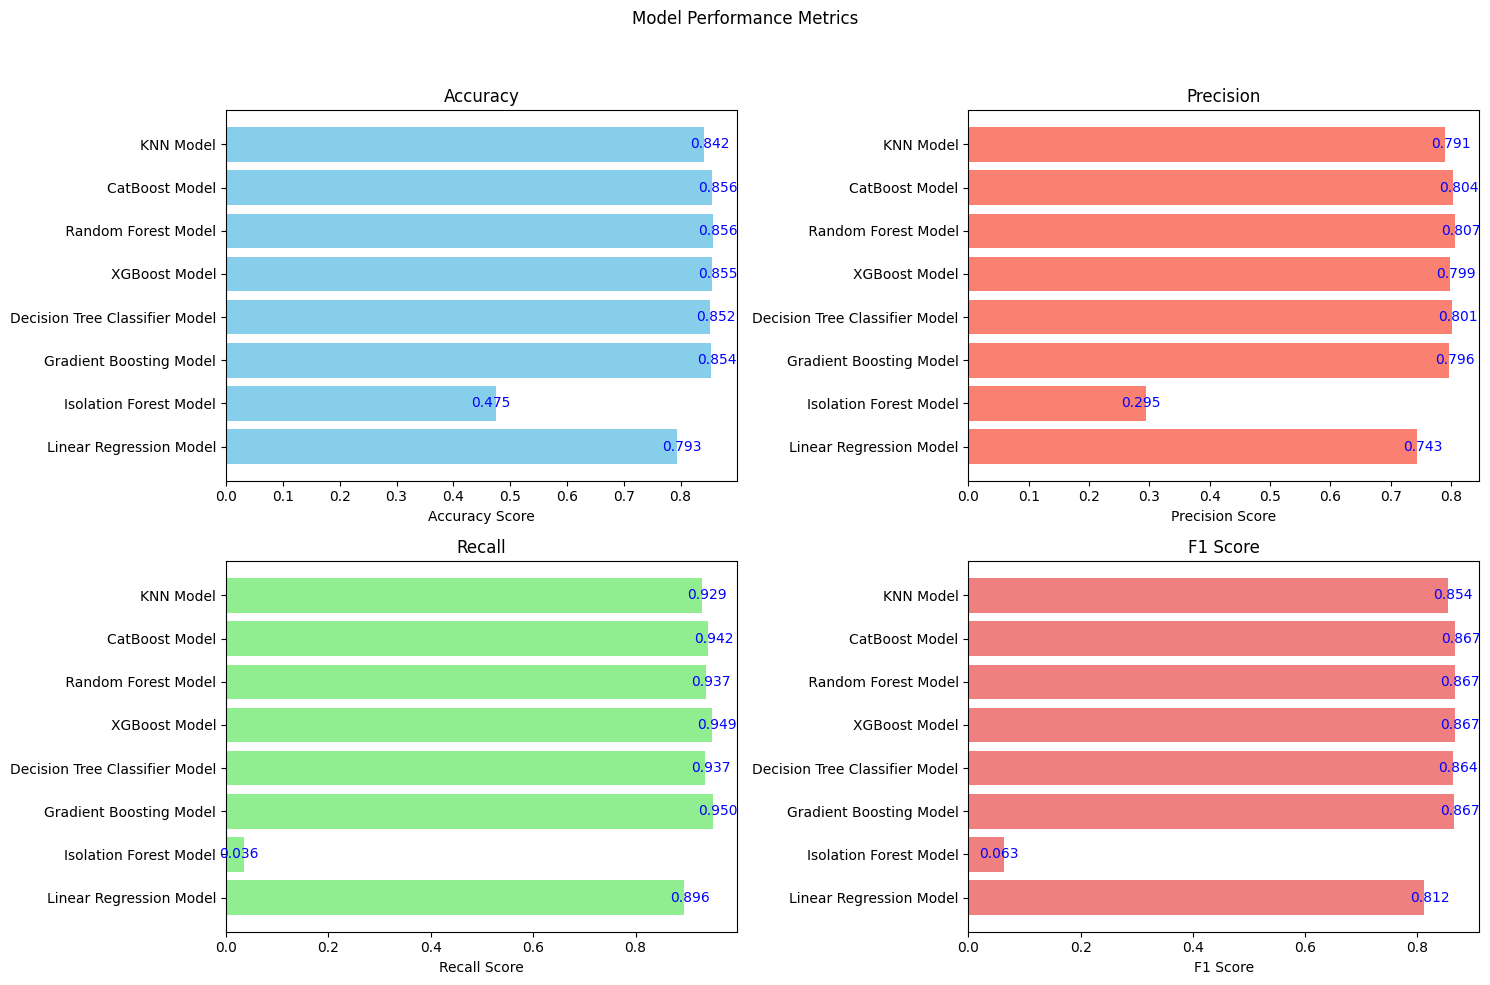

In [62]:
# Filter out invalid entries (where f1_score is not a float or int)
results_cleaned = [res for res in results if isinstance(res['f1_score'], (float, int))]

#Extracting the data
model_names = [res['name'] for res in results_cleaned]
accuracy_scores = [res["accuracy"] for res in results_cleaned]
precision_scores = [res["precision"] for res in results_cleaned]
recall_scores = [res["recall"] for res in results_cleaned]
f1_scores = [res['f1_score'] for res in results_cleaned]

# Creating the bar plots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Model Performance Metrics')

# Function to add text annotations
def add_text_annotations(ax, scores, model_names):
    for i, (v, name) in enumerate(zip(scores, model_names)):
        if name == 'Isolation Forest Model':
            ax.text(v - 0.01, i, f"{v:.3f}", color='blue', ha='center', va='center')
        else:
            ax.text(v + 0.01, i, f"{v:.3f}", color='blue', ha='center', va='center')

# Accuracy
axs[0, 0].barh(model_names, accuracy_scores, color='skyblue')
axs[0, 0].set_title('Accuracy')
axs[0, 0].set_xlabel('Accuracy Score')
add_text_annotations(axs[0, 0], accuracy_scores, model_names)

# Precision
axs[0, 1].barh(model_names, precision_scores, color='salmon')
axs[0, 1].set_title('Precision')
axs[0, 1].set_xlabel('Precision Score')
add_text_annotations(axs[0, 1], precision_scores, model_names)

# Recall
axs[1, 0].barh(model_names, recall_scores, color='lightgreen')
axs[1, 0].set_title('Recall')
axs[1, 0].set_xlabel('Recall Score')
add_text_annotations(axs[1, 0], recall_scores, model_names)

# F1 Score
axs[1, 1].barh(model_names, f1_scores, color='lightcoral')
axs[1, 1].set_title('F1 Score')
axs[1, 1].set_xlabel('F1 Score')
add_text_annotations(axs[1, 1], f1_scores, model_names)

# Adjusting layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Results

The evaluation of multiple machine learning models for detecting fraudulent vehicle insurance claims yielded the following performance metrics: accuracy, precision, recall, and F1 score. The results are summarized below:

1. Accuracy
    - CatBoost and Random Forest models achieved the highest accuracy scores of 0.856.
    - XGBoost, Gradient Boosting, and Decision Tree Classifier models followed closely with accuracy scores of 0.855, 0.854, and 0.852, respectively.
    - The KNN model showed a slightly lower accuracy of 0.842.
    - Linear Regression achieved an accuracy of 0.793.
    - The Isolation Forest model had the lowest accuracy score of 0.475.

2. Precision
    - Random Forest, CatBoost, and Decision Tree Classifier models exhibited high precision scores of 0.807, 0.804, and 0.801, respectively.
    - XGBoost, Gradient Boosting, and KNN followed with scores of 0.799, 0.796, and 0.791.
    - Linear Regression achieved a precision of 0.743.
    - The Isolation Forest model had the lowest precision score of 0.295.  

3. Recall
     - Gradient Boosting led with the highest recall score of 0.950.
     - XGBoost and CatBoost followed with recall scores of 0.949 and 0.942, respectively.
     - Random Forest and Decision Tree Classifier both had recall scores of 0.937, while KNN followed at 0.929.
     - Linear Regression achieved a recall of 0.896.
     - Isolation Forest model had a significantly lower recall score of 0.036.

4. F1 Score
   - CatBoost, Random Forest, Gradient Boosting, and XGBoost models all achieved top F1 scores of 0.867.
   - Decision Tree Classifier and KNN also performed well, with F1 scores of 0.864 and 0.854, respectively.
   - Linear Regression achieved an F1 score of 0.812.
   - The Isolation Forest model had the lowest F1 score of 0.063.



# Conclusion
This evaluation of several machine learning models for detecting fraudulent vehicle insurance claims provides clear evidence of their relative strengths. CatBoost emerged as the best overall performer, achieving top scores in accuracy, precision, recall, and F1 score. Its high recall, in particular, highlights its ability to correctly identify a large proportion of fraudulent claims, making it a strong choice for reducing false negatives in a fraud detection context.

Random Forest and XGBoost also delivered consistently high performance across all metrics, making them strong alternatives or complementary models. Both offer a solid balance between identifying true fraud cases (recall) and minimizing false alarms (precision), which is crucial in operational settings.

In contrast, the Isolation Forest model performed poorly across all metrics. This outcome is expected, as Isolation Forest is designed for unsupervised anomaly detection rather than supervised classification, making it a less appropriate choice for this task.

Based on the results, deploying the CatBoost model is recommended for fraud detection in vehicle insurance claims, with Random Forest or XGBoost as viable backup or ensemble options. Using these models can help insurers improve detection accuracy, reduce financial losses, and protect legitimate customers from unfair premium increases. To maintain effectiveness, it’s important to regularly monitor and retrain these models as fraud patterns evolve.